**Practical introduction to Machine Learning : Practical Session 2 Regression**

The goal of this practical session was to explore and understand the machine learning methods discussed in the course by applying them to real data. The dataset came from the BCI Competition IV, specifically focusing on predicting the thumb flexion of subject 3 from ECoG signals.

During the session, we preprocessed the data, visualized ECoG signals and finger movements, and experimented with different regression techniques, including Least Squares, Ridge, Lasso, and nonlinear models such as SVR, Random Forest, and MLP. We evaluated model performance using MSE and R², compared coefficients, and explored the impact of regularization, network architecture, and hyperparameters.

In [127]:
import numpy as np
import pylab as pl
import scipy as sp
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

**Partie 2 : Data visualization and pre-processing**

In [128]:
#dE = np.load('/Users/alexisbezacier/Desktop/M2DS/Remy/Lab2/ECoG.npz')
dE = np.load('/content/ECoG.npz')

In [129]:
X = dE['Xall']
Yall = dE['Yall']
Fe = dE['Fe']
t = np.arange(X.shape[0]) / Fe # time axis for each measure
print(len(X))
print(len(Yall))
print(X)
print(Fe)

print(X[0].shape)
print(t)
print(t.shape)
print(Yall.shape)

print(Yall)


3327
3327
[[-1.3737837  -1.30303518  0.43729182 ... -0.93392455  1.11421623
  -3.1298364 ]
 [-1.40754509 -1.31210178  0.68126325 ... -1.32030805  1.15182847
  -3.11345062]
 [-1.22628058 -1.50097747  0.85706294 ... -1.72732982  1.12268174
  -3.12009611]
 ...
 [ 0.0599531  -0.55449127  0.0202913  ... -0.5885793  -0.57915436
   0.87131507]
 [-0.04894087 -0.39938902  0.16811176 ... -0.46252679 -0.48357235
   0.75185823]
 [-0.07524357 -0.23820004  0.35198339 ... -0.36208017 -0.33437349
   0.64894091]]
[[50]]
(64,)
[[0.000e+00 2.000e-02 4.000e-02 ... 6.648e+01 6.650e+01 6.652e+01]]
(1, 3327)
(3327, 1)
[[-0.72565782]
 [-0.72219318]
 [-0.71872854]
 ...
 [-0.37919401]
 [-0.35494155]
 [-0.33068908]]


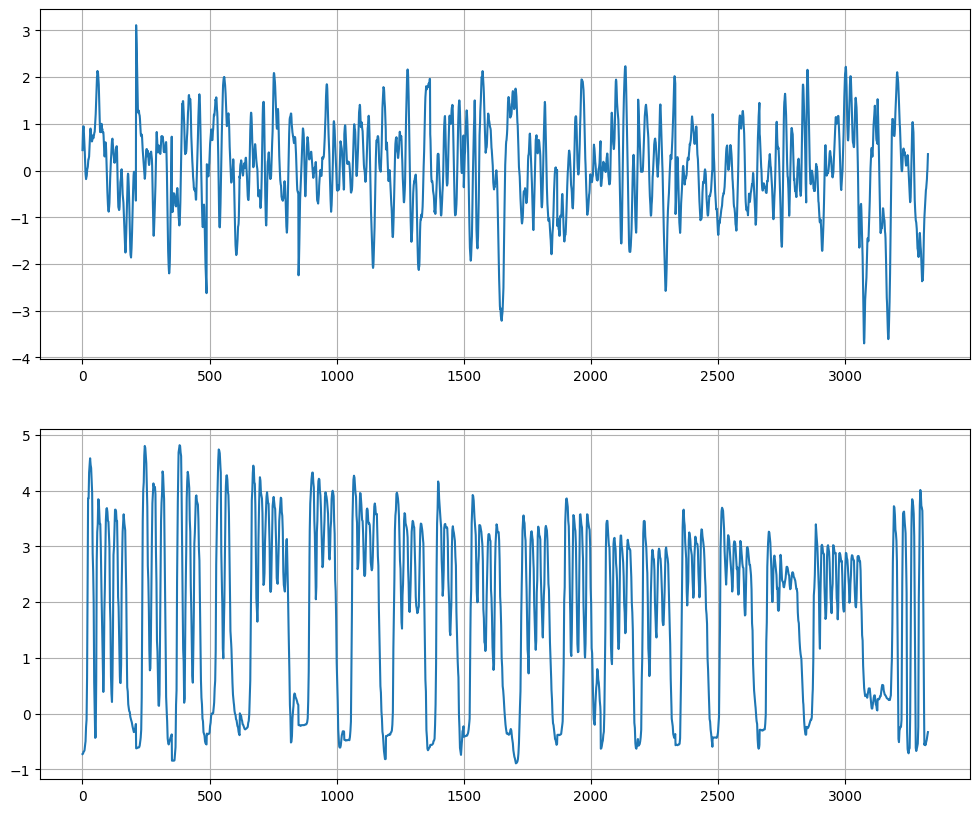

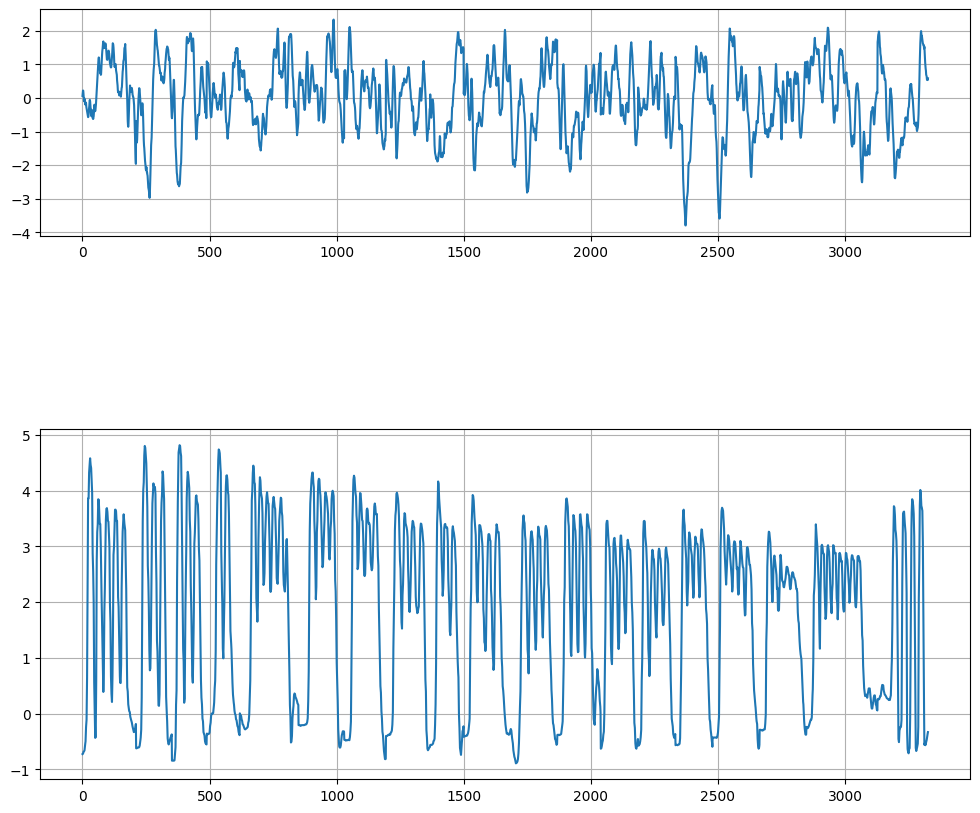

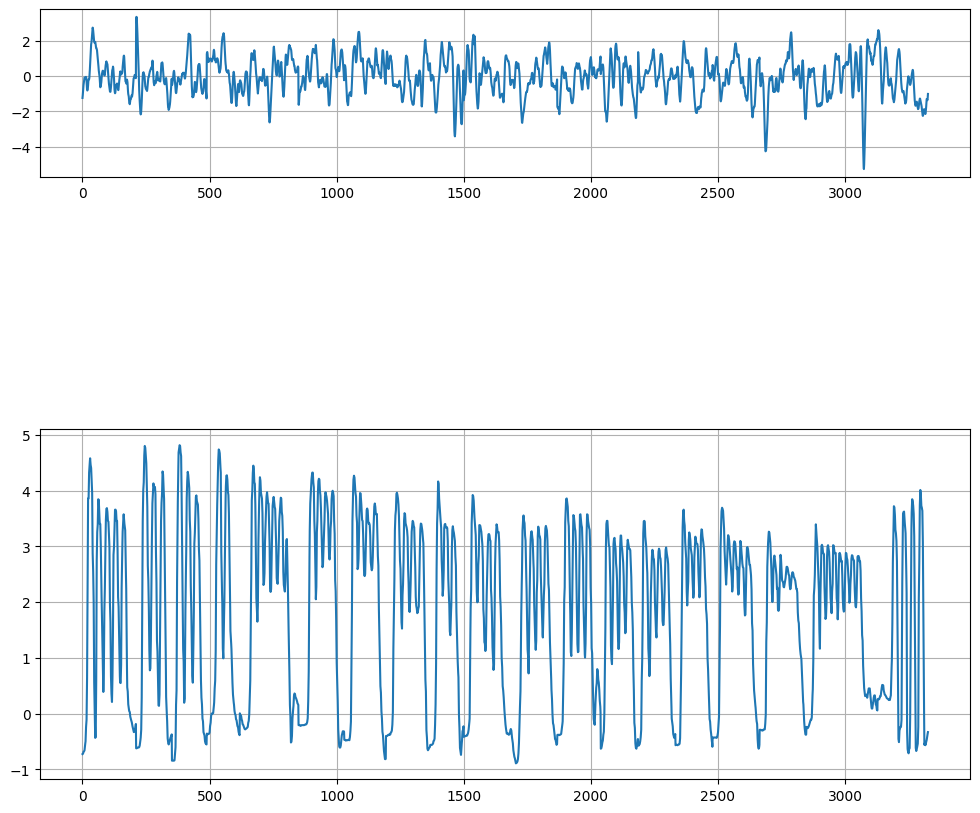

In [130]:
for i in range(2, 5):
    pl.figure(figsize=(12,10))

    pl.subplot(i,1,1)
    pl.plot(X[:,i])
    pl.grid()
    pl.subplot(2,1,2)
    pl.plot(Yall)
    pl.grid()
    pl.show()

# Graphs of the position of all the electrod at the time i

In fact, I see no correlation between the ECOG signals measured in the brain and finger movement.

When studying the data, I really struggled to understand the dataset and even the dimensions of the different objects (X, Y).

The samples are the different observations, in this case the measurements, and the labels are the positions of the thumb.

3327
3327
[-1.3737837  -1.30303518  0.43729182  0.05907264 -1.23354338 -1.85180049
  0.19208955 -1.28047189  0.47706429 -1.12775594 -0.69895286 -0.36916996
 -0.36658527  0.0494699   0.9364424  -0.27309409 -0.21996618  1.42705275
  0.2298589   0.09032635 -2.7030526  -1.14127999  1.14555181  0.73521396
 -1.10186511  0.4392573  -0.31984386 -3.11037511  1.26832941  2.35108353
  0.91883143  0.8613407  -1.01595443 -2.07834311  0.95668359 -0.05606344
 -0.1914756  -0.19393317 -0.98844543 -2.20738649 -0.07194835 -2.64996409
  0.02223886 -0.47306502 -0.4711089  -0.21370491  0.59867752 -0.02412049
 -0.04172096 -0.69657999 -1.57719772  0.88620905 -0.03629439  0.08802792
 -2.49950612  0.08789629  0.13312862 -2.47415009 -0.45410741 -0.65373946
  0.31088804 -0.93392455  1.11421623 -3.1298364 ]


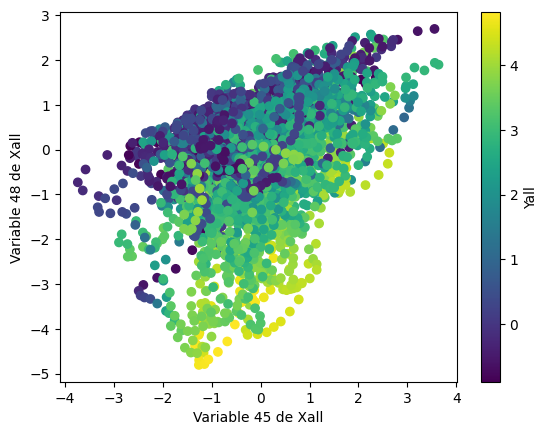

In [131]:
print(X.shape[0])
print(Yall.shape[0])
print(X[0])
pl.scatter(X[:,45], X[:,48], c=Yall)
pl.colorbar(label='Yall')
pl.xlabel('Variable 45 de Xall')
pl.ylabel('Variable 48 de Xall')
pl.show()

We're visualising the link between the two ECoG signals and the finger movement.

If the points are in the same color, the electrods 45 and 48 are linked. If it is not clear, there is no clear relation.

We're visualizing the relationship between two ECoG signals (electrodes 45 and 48) and finger movement.

The plot reveals a clear linear relationship between electrodes 45 and 48, indicating these two electrodes are highly correlated and likely located in similar brain regions involved in motor control.

So, the two electrodes show a strong positive correlation (diagonal pattern). We notice different finger flexion levels form distinct clusters along this correlation axis

This correlation explains why these electrodes are among the most important features selected by Lasso regression


In [132]:
X_train=X[:1000,:]
X_test=X[1000:,:]
Y_train=Yall[:1000,:]
Y_test=Yall[1000:,:]
print(f"Y_test shape: {Y_test.shape}")


Y_test shape: (2327, 1)


**Partie 3 : Least Squares regression (LS)**


In [133]:
X_hat_train = np.concatenate((np.ones((X_train.shape[0],1)),X_train), axis=1)
X_hat_test  = np.concatenate((np.ones((X_test.shape[0],1)), X_test), axis=1)
print(X_hat_train)

[[ 1.         -1.3737837  -1.30303518 ... -0.93392455  1.11421623
  -3.1298364 ]
 [ 1.         -1.40754509 -1.31210178 ... -1.32030805  1.15182847
  -3.11345062]
 [ 1.         -1.22628058 -1.50097747 ... -1.72732982  1.12268174
  -3.12009611]
 ...
 [ 1.         -0.09589467 -0.4130038  ...  1.572188   -0.54075572
   0.87862899]
 [ 1.         -0.09756581 -0.11680789 ...  1.78996188 -0.50905215
   1.06557003]
 [ 1.         -0.16724784  0.11089083 ...  1.83114964 -0.39857839
   1.16830132]]


In [134]:
A = X_hat_train.T @ X_hat_train
b = X_hat_train.T @ Y_train
w = np.linalg.solve(A, b)

print(w)
print(b)

[[ 1.90081255]
 [-0.09150694]
 [ 0.10861623]
 [-0.07305774]
 [-0.27938349]
 [ 0.25112061]
 [ 0.41213833]
 [ 0.14387528]
 [-0.19811799]
 [ 0.40869961]
 [ 0.7059866 ]
 [-0.4557358 ]
 [ 0.02140866]
 [ 0.35947183]
 [-0.01042572]
 [-0.17655887]
 [-0.03377368]
 [-0.11345198]
 [-0.72143135]
 [-0.5950915 ]
 [ 0.23329595]
 [-0.65132811]
 [-0.33317441]
 [ 0.28861537]
 [ 0.24498034]
 [ 0.22062027]
 [ 0.19042788]
 [ 0.20709995]
 [ 0.3273775 ]
 [-0.65410592]
 [ 0.11997444]
 [-0.07491945]
 [ 0.10667581]
 [ 0.11003235]
 [-0.42910159]
 [-0.22329342]
 [-0.00381723]
 [-0.06046664]
 [-0.1595164 ]
 [-0.48519392]
 [ 0.15019433]
 [ 0.25855769]
 [-0.09242374]
 [ 0.76314124]
 [-0.0834797 ]
 [ 0.04489988]
 [-0.16816255]
 [ 0.04845934]
 [ 0.0256902 ]
 [-1.03905805]
 [ 0.16060454]
 [-0.19110549]
 [ 0.16557271]
 [ 0.08064689]
 [ 0.27554638]
 [-0.01162067]
 [-0.00740264]
 [ 0.33850545]
 [ 0.22409642]
 [-0.2196636 ]
 [-0.26866884]
 [-0.16469195]
 [-0.23638421]
 [ 0.04244268]
 [ 0.5694358 ]]
[[ 1944.32740071]
 [  26

In [135]:
Y_train_pred = X_hat_train @ w
Y_test_pred  = X_hat_test @ w
print(Y_test_pred.shape)
print(Y_train_pred.shape)

(2327, 1)
(1000, 1)


Solving the LSE method by hand this time, after which we will use the scikit-learn library function.

In [136]:
intercept = w[0]
coef = w[1:]

print("Intercept:", intercept)
print("Coefficients:", coef)

Intercept: [1.90081255]
Coefficients: [[-0.09150694]
 [ 0.10861623]
 [-0.07305774]
 [-0.27938349]
 [ 0.25112061]
 [ 0.41213833]
 [ 0.14387528]
 [-0.19811799]
 [ 0.40869961]
 [ 0.7059866 ]
 [-0.4557358 ]
 [ 0.02140866]
 [ 0.35947183]
 [-0.01042572]
 [-0.17655887]
 [-0.03377368]
 [-0.11345198]
 [-0.72143135]
 [-0.5950915 ]
 [ 0.23329595]
 [-0.65132811]
 [-0.33317441]
 [ 0.28861537]
 [ 0.24498034]
 [ 0.22062027]
 [ 0.19042788]
 [ 0.20709995]
 [ 0.3273775 ]
 [-0.65410592]
 [ 0.11997444]
 [-0.07491945]
 [ 0.10667581]
 [ 0.11003235]
 [-0.42910159]
 [-0.22329342]
 [-0.00381723]
 [-0.06046664]
 [-0.1595164 ]
 [-0.48519392]
 [ 0.15019433]
 [ 0.25855769]
 [-0.09242374]
 [ 0.76314124]
 [-0.0834797 ]
 [ 0.04489988]
 [-0.16816255]
 [ 0.04845934]
 [ 0.0256902 ]
 [-1.03905805]
 [ 0.16060454]
 [-0.19110549]
 [ 0.16557271]
 [ 0.08064689]
 [ 0.27554638]
 [-0.01162067]
 [-0.00740264]
 [ 0.33850545]
 [ 0.22409642]
 [-0.2196636 ]
 [-0.26866884]
 [-0.16469195]
 [-0.23638421]
 [ 0.04244268]
 [ 0.5694358 ]]


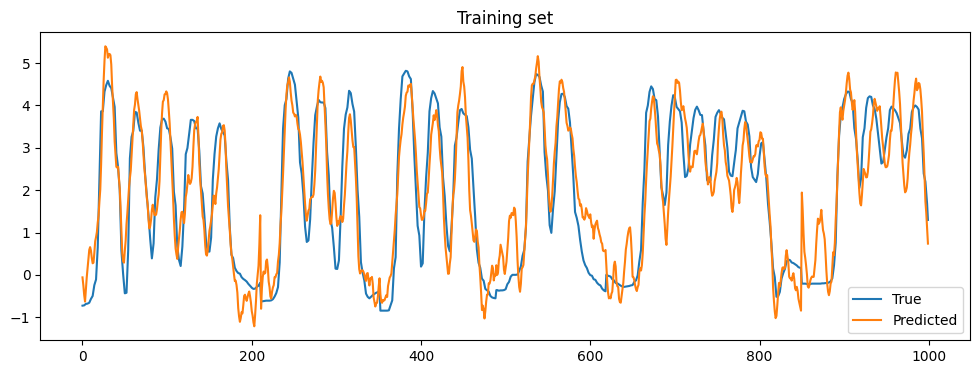

In [137]:
pl.figure(figsize=(12,4))
pl.plot(Y_train, label='True')
pl.plot(Y_train_pred, label='Predicted')
pl.title("Training set")
pl.legend()
pl.show()

The blue curve = real
The orange curve = predict by the model

R squared = 0.839 -> the curve are nearly the same because the variance is 84 %

The pics are well predicted but just below 600 there is a big difference betwenn the 2 curves that can be a proof of the limits of the linear model

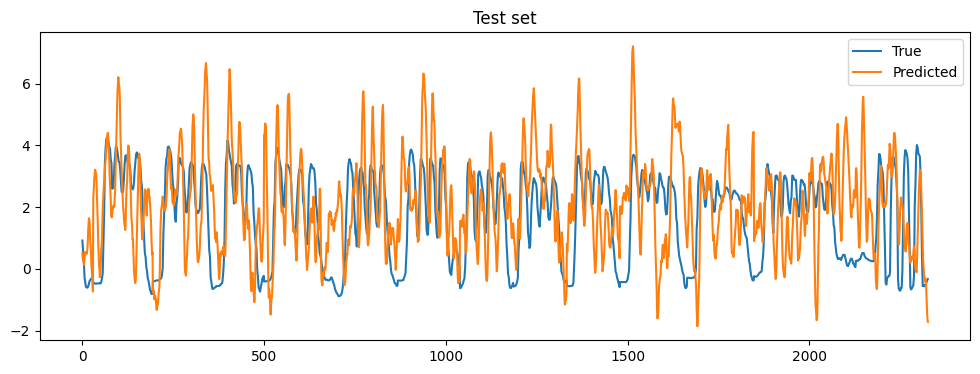

In [138]:
pl.figure(figsize=(12,4))
pl.plot(Y_test, label='True')
pl.plot(Y_test_pred, label='Predicted')
pl.title("Test set")
pl.legend()
pl.show()

Here is the zoo, the prediction is random, no correlation between the two curves. the amplitude are too huge


After all that can be explained by the R squared that is negative.

That's a case of overfitting

In [139]:
# Calcul de MSE :
MSE_train_LS = mean_squared_error(Y_train, Y_train_pred)
MSE_test_LS  = mean_squared_error(Y_test, Y_test_pred)

# Calcul de R carré :
R_train_LS = r2_score(Y_train, Y_train_pred)
R_test_LS  = r2_score(Y_test, Y_test_pred)
print(MSE_train_LS)
print(MSE_test_LS)
print(R_train_LS)
print(R_test_LS)

0.5040654614476062
3.0455368767601625
0.8395001217500111
-0.42817006302225247


Results obtained
- MSE Train_LS: 0.504
- MSE Test_LS: 3.045
- R² Train_LS: 0.839
- R² Test_LS: -0.428

The model performs well on training with an R² of 0.840, which means that it explains 84% of the variance in the training data. This high value indicates that the model captures the patterns well to predict finger flexion.

Overfitting is detected because of the huge difference between R²_train_LS (0.840) and R²_test_LS (-0.428).

The model generalizes poorly because
the test MSE (3.045) is 6 times higher than the train MSE (0.504)

Overfitting explanations:
- 65 parameters for only 1,000 training samples.
- Absence of regularization, which is performed afterwards.

In [140]:
lin_model = linear_model.LinearRegression()
lin_model.fit(X_train, Y_train)

Y_pred_train_lin = lin_model.predict(X_train)
Y_pred_test_lin  = lin_model.predict(X_test)

print("Linear Regression coefficients:")
print(lin_model.coef_)
print("Linear Regression intercept:")
print(lin_model.intercept_)

Linear Regression coefficients:
[[-0.09150694  0.10861623 -0.07305774 -0.27938349  0.25112061  0.41213833
   0.14387528 -0.19811799  0.40869961  0.7059866  -0.4557358   0.02140866
   0.35947183 -0.01042572 -0.17655887 -0.03377368 -0.11345198 -0.72143135
  -0.5950915   0.23329595 -0.65132811 -0.33317441  0.28861537  0.24498034
   0.22062027  0.19042788  0.20709995  0.3273775  -0.65410592  0.11997444
  -0.07491945  0.10667581  0.11003235 -0.42910159 -0.22329342 -0.00381723
  -0.06046664 -0.1595164  -0.48519392  0.15019433  0.25855769 -0.09242374
   0.76314124 -0.0834797   0.04489988 -0.16816255  0.04845934  0.0256902
  -1.03905805  0.16060454 -0.19110549  0.16557271  0.08064689  0.27554638
  -0.01162067 -0.00740264  0.33850545  0.22409642 -0.2196636  -0.26866884
  -0.16469195 -0.23638421  0.04244268  0.5694358 ]]
Linear Regression intercept:
[1.90081255]


The coefficients and the linear regression intercept are the same

**Part 4 : Ridge regression**

In [141]:
from sklearn import linear_model

ridge_model = linear_model.Ridge(alpha=1)

ridge_model.fit(X_train, Y_train)


y_pred_train = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test)


mse_train_Ridge = mean_squared_error(Y_train, y_pred_train)
mse_test_Ridge = mean_squared_error(Y_test, y_pred_test)

r2_train_Ridge = r2_score(Y_train, y_pred_train)
r2_test_Ridge = r2_score(Y_test, y_pred_test)

print(f"mse_train_Ridge = {mse_train_Ridge}")
print(f"mse_test_Ridge = {mse_test_Ridge}")
print(f"r2_train_Ridge = {r2_train_Ridge}")
print(f"r2_test_Ridge = {r2_test_Ridge}")

mse_train_Ridge = 0.5041768297327898
mse_test_Ridge = 3.0038429595355707
r2_train_Ridge = 0.8394646608871272
r2_test_Ridge = -0.40861817223916197


The results are approximately the same as before, which indicates that the model’s performance has not improved.
In fact, r2_test<0, meaning the model generalizes very poorly. It performs worse than a simple model that would always predict the mean of the target variable. Moreover, mse_train << mse_test so that means that the model is overfitting and it nececcitates a regularization of the data.

In [142]:
lambdas = np.logspace(-3, 5, 100)

mse_train_list = []
mse_test_list = []
coefs = []

for l in lambdas:
    ridge_model = linear_model.Ridge(alpha=l)
    ridge_model.fit(X_train, Y_train)


    y_pred_train = ridge_model.predict(X_train)
    y_pred_test = ridge_model.predict(X_test)


    mse_train_Ridge = mean_squared_error(Y_train, y_pred_train)
    mse_test_Ridge = mean_squared_error(Y_test, y_pred_test)


    mse_train_list.append(mse_train_Ridge)
    mse_test_list.append(mse_test_Ridge)
    coefs.append(ridge_model.coef_)

coefs = np.array(coefs)

In [143]:
print(lambdas)
print(mse_train_list)

[1.00000000e-03 1.20450354e-03 1.45082878e-03 1.74752840e-03
 2.10490414e-03 2.53536449e-03 3.05385551e-03 3.67837977e-03
 4.43062146e-03 5.33669923e-03 6.42807312e-03 7.74263683e-03
 9.32603347e-03 1.12332403e-02 1.35304777e-02 1.62975083e-02
 1.96304065e-02 2.36448941e-02 2.84803587e-02 3.43046929e-02
 4.13201240e-02 4.97702356e-02 5.99484250e-02 7.22080902e-02
 8.69749003e-02 1.04761575e-01 1.26185688e-01 1.51991108e-01
 1.83073828e-01 2.20513074e-01 2.65608778e-01 3.19926714e-01
 3.85352859e-01 4.64158883e-01 5.59081018e-01 6.73415066e-01
 8.11130831e-01 9.77009957e-01 1.17681195e+00 1.41747416e+00
 1.70735265e+00 2.05651231e+00 2.47707636e+00 2.98364724e+00
 3.59381366e+00 4.32876128e+00 5.21400829e+00 6.28029144e+00
 7.56463328e+00 9.11162756e+00 1.09749877e+01 1.32194115e+01
 1.59228279e+01 1.91791026e+01 2.31012970e+01 2.78255940e+01
 3.35160265e+01 4.03701726e+01 4.86260158e+01 5.85702082e+01
 7.05480231e+01 8.49753436e+01 1.02353102e+02 1.23284674e+02
 1.48496826e+02 1.788649

The lambdas varies hugely instead of the mse values that are not a lot. So we'll use a semi-logarithmic scale ton plot this values

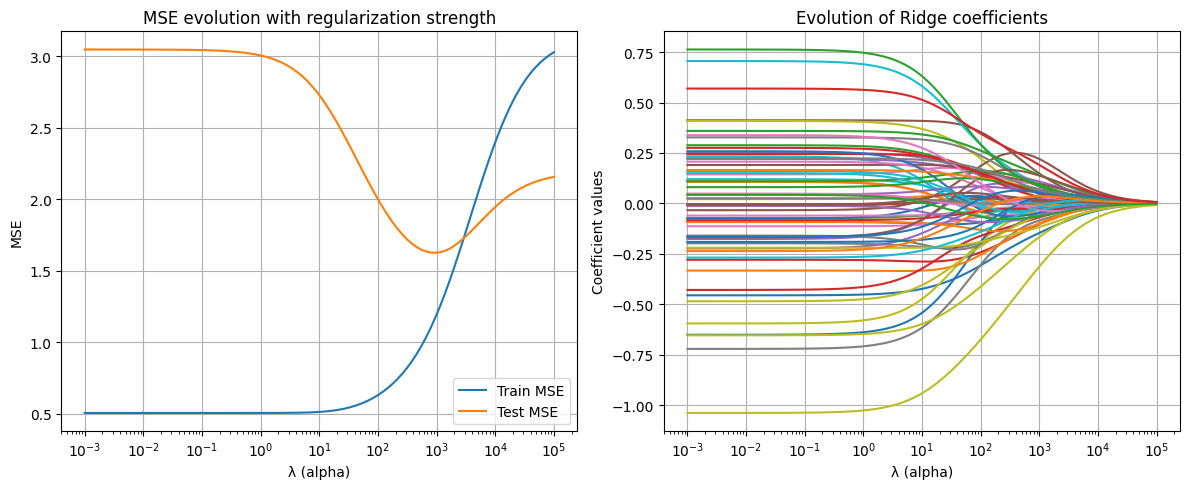

In [144]:
pl.figure(figsize=(12, 5))

pl.subplot(1, 2, 1)
pl.semilogx(lambdas, mse_train_list, label="Train MSE")
pl.semilogx(lambdas, mse_test_list, label="Test MSE")
pl.xlabel("λ (alpha)")
pl.ylabel("MSE")
pl.title("MSE evolution with regularization strength")
pl.legend()
pl.grid(True)

pl.subplot(1, 2, 2)
pl.semilogx(lambdas, coefs)   # logarithmic scale
pl.xlabel("λ (alpha)")
pl.ylabel("Coefficient values")
pl.title("Evolution of Ridge coefficients")
pl.grid(True)

pl.tight_layout()
pl.show()



When lambda is near 0, the model trained is approximately the same thing as LSE, so we notice a clearly overfitting.

When lambda is high(10**5), we notice that mse_train > mse_test, that means that the test data set still help to learn the model wich means that the model is underfitting.The model is too simple to capture the underlying structure of the data.

So we need to fin a value of lambda in between that induces a balanced regularization for the model

In [145]:
best_idx = np.argmin(mse_test_list)
best_lambda = lambdas[best_idx]
print("Best λ:", best_lambda)


Best λ: 954.5484566618347


Important to note tha twe could have compute the GridSearchCV and the RidgeCV to find the best lambdas. This methods give lambda = 215 which leads to a worse generalization but to a better accuracy

In [146]:
ridge_model = linear_model.Ridge(alpha=954)

ridge_model.fit(X_train, Y_train)


y_pred_train = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test)


mse_train_Ridge_Optimized = mean_squared_error(Y_train, y_pred_train)
mse_test_Ridge_Optimized = mean_squared_error(Y_test, y_pred_test)

r2_train_Ridge_Optimized = r2_score(Y_train, y_pred_train)
r2_test_Ridge_Optimized = r2_score(Y_test, y_pred_test)

print(f"mse_train_Ridge_Optimized = {mse_train_Ridge_Optimized}")
print(f"mse_test_Ridge_Optimized = {mse_test_Ridge_Optimized}")
print(f"r2_train_Ridge_Optimized = {r2_train_Ridge_Optimized}")
print(f"r2_test_Ridge_Optmized = {r2_test_Ridge_Optimized}")

mse_train_Ridge_Optimized = 1.171706460516052
mse_test_Ridge_Optimized = 1.6239022640982905
r2_train_Ridge_Optimized = 0.6269160284906783
r2_test_Ridge_Optmized = 0.23848940508433292


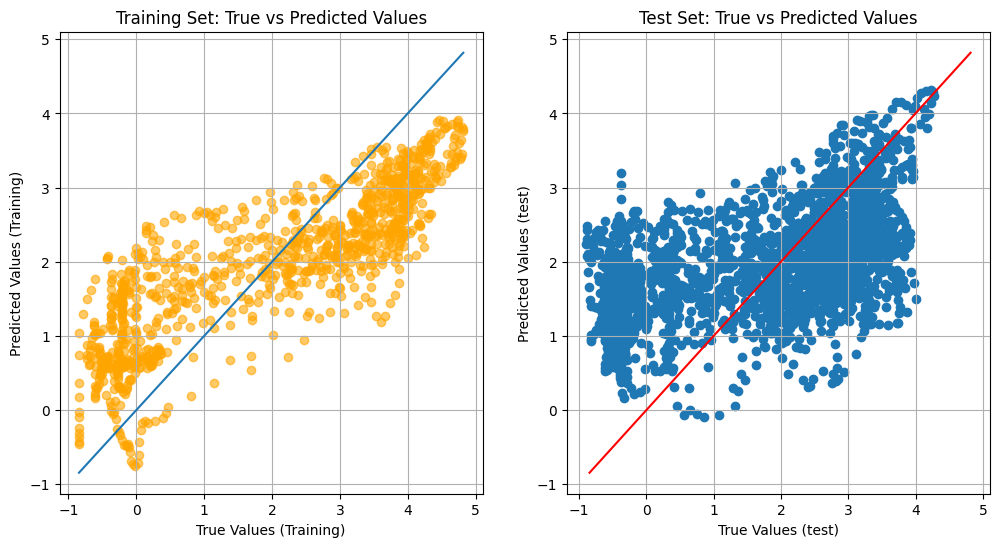

In [147]:
pl.figure(figsize=(12,6))
pl.subplot(1, 2, 1)
pl.scatter(Y_train, y_pred_train, alpha=0.6, color='orange')
pl.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()])
pl.xlabel('True Values (Training)')
pl.xlabel('True Values (Training)')
pl.ylabel('Predicted Values (Training)')
pl.title('Training Set: True vs Predicted Values')
pl.grid()

pl.subplot(1, 2, 2)
pl.scatter(Y_test, y_pred_test)
pl.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()],'r')
pl.xlabel('True Values (test)')
pl.ylabel('Predicted Values (test)')
pl.title('Test Set: True vs Predicted Values')
pl.grid()

Bad generalisation of the data (overfitting)

The Ridge regression model performs moderately well on the training data, capturing a significant portion of the variance. However, its ability to generalize to unseen data is limited, as indicated by the much lower R² and higher MSE on the test set, suggesting that the model may be underfitting or that the current feature set does not fully capture the underlying patterns.

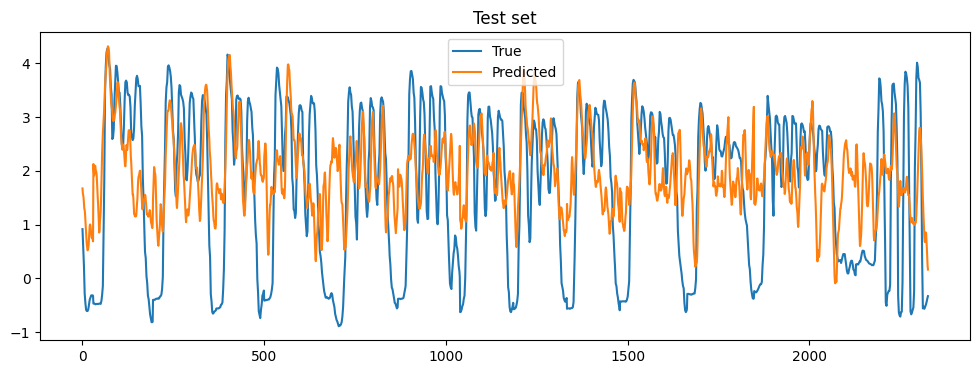

In [148]:
pl.figure(figsize=(12,4))
pl.plot(Y_test, label='True')
pl.plot(y_pred_test, label='Predicted')
pl.title("Test set")
pl.legend()
pl.show()

The predicted curve is a bit better than the one of LSE. But it still doesn't caputre the full amplitude of the true signal. We have to find an other model to make the prediction fits better.

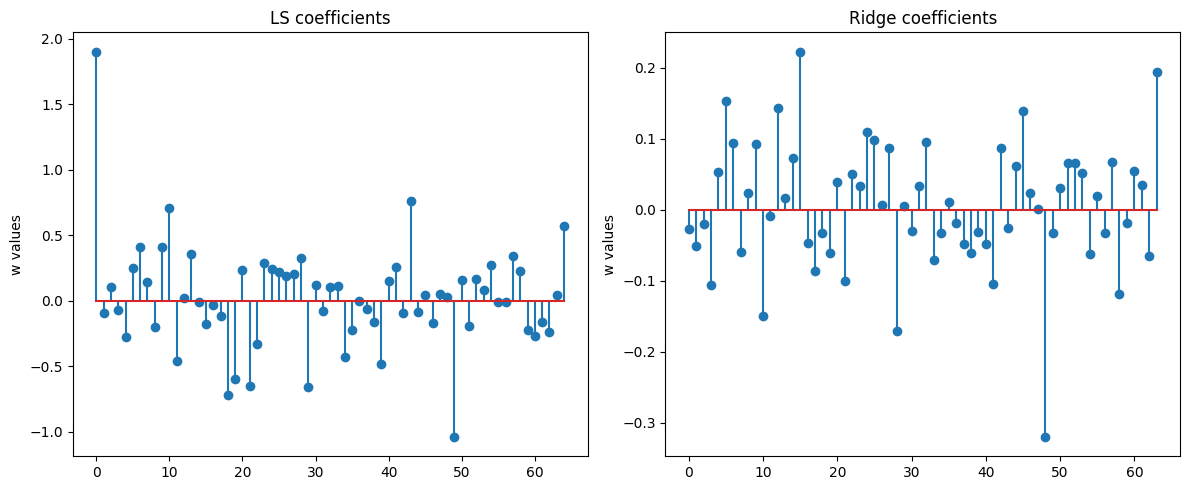

In [149]:
w_ls = w
w_ridge = ridge_model.coef_
pl.figure(figsize=(12, 5))
pl.subplot(1,2,1)
pl.stem(w_ls)
pl.title("LS coefficients")
pl.ylabel("w values")
pl.subplot(1,2,2)
pl.title("Ridge coefficients")
pl.stem(w_ridge)
pl.title("Ridge coefficients")
pl.ylabel("w values")

pl.tight_layout()
pl.show()



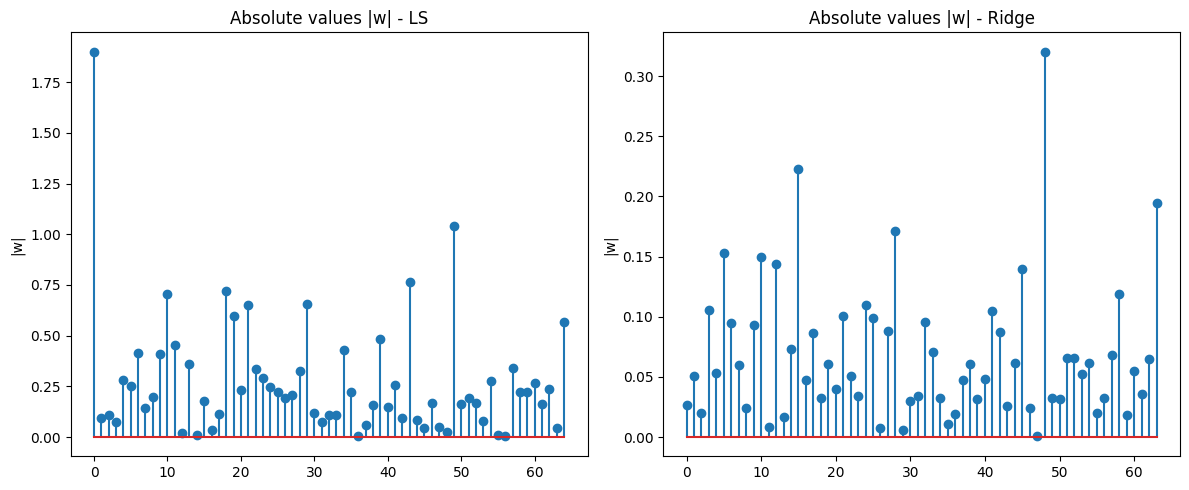

In [150]:
pl.figure(figsize=(12, 5))

pl.subplot(1, 2, 1)
pl.stem(np.abs(w_ls))
pl.title("Absolute values |w| - LS")

pl.ylabel('|w|')

pl.subplot(1, 2, 2)
pl.stem(np.abs(w_ridge))
pl.title("Absolute values |w| - Ridge")
pl.ylabel('|w|')

pl.tight_layout()
pl.show()

The comparison between LS and Ridge coefficients clearly shows the benefits of regularization.

Least Squares Problems: The LS model has serious issues with its coefficients. The first coefficient reaches an extreme value of around 1.9, which is a clear sign of overfitting. Many other coefficients also have large positive and negative values that seem random and unstable. We see here that LS is really sensitive to noise.

Ridge Regularization: Ridge regression seems to fixe these problems effectively. All coefficients are now controlled and stay within a reasonable range (between -0.6 and +0.3). The regularization penalty forces the model to use smaller coefficient values. Ridge is particularly useful when the variables are correlated.

**5 Variable selection with the Lasso**

In [151]:
Lasso_model = Lasso()

Lasso_model.fit(X_train, Y_train)

print(Lasso_model.coef_)
print(Lasso_model.intercept_)
print(X_train.shape)
print(np.var(X_train))

[ 0.  0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0. -0.
  0. -0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0. -0. -0. -0.
 -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.
  0.  0. -0.  0. -0.  0.  0.  0. -0.  0.]
[1.9443274]
(1000, 64)
1.0124371467469326


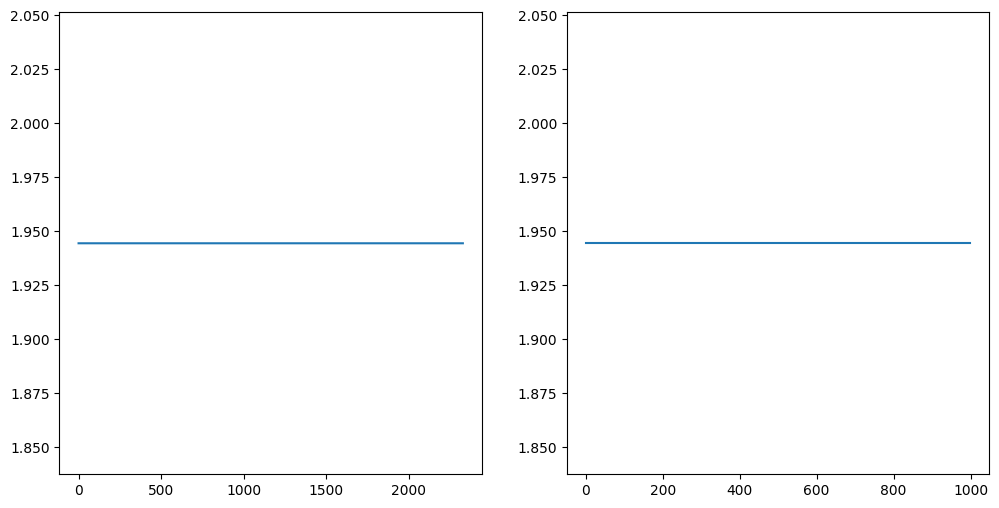

In [152]:
pl.figure(figsize=(12,6))
pl.subplot(1,2,1)
y_pred_test = Lasso_model.predict(X_test)
pl.plot(y_pred_test)
pl.subplot(1,2,2)
y_pred_train = Lasso_model.predict(X_train)
pl.plot(y_pred_train)

This is unusual: all the coefficients are close to zero. Possibly, the default alpha value of 1 is too high, causing the Lasso regularization to shrink the coefficients excessively.

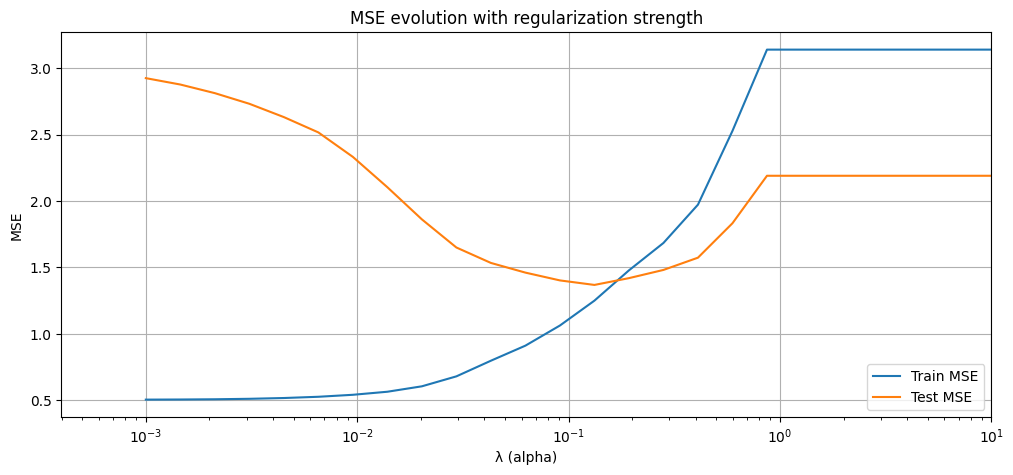

In [153]:
lmbda = np.logspace(-3, 5, 50)
Mse_train_Lasso =[]
Mse_test_Lasso=[]

for lmbd in lmbda:
    lasso_model = Lasso(alpha=lmbd)
    lasso_model.fit(X_train, Y_train)
    y_pred_train = lasso_model.predict(X_train)
    y_pred_test = lasso_model.predict(X_test)
    mse_train_Lasso = mean_squared_error(Y_train, y_pred_train)
    mse_test_Lasso= mean_squared_error(Y_test, y_pred_test)

    Mse_train_Lasso.append(mse_train_Lasso)
    Mse_test_Lasso.append(mse_test_Lasso)



pl.figure(figsize=(12, 5))

pl.semilogx(lmbda, Mse_train_Lasso, label="Train MSE")
pl.semilogx(lmbda, Mse_test_Lasso, label="Test MSE")
pl.xlabel("λ (alpha)")
pl.ylabel("MSE")
pl.title("MSE evolution with regularization strength")
pl.xlim(0,10**1)
pl.legend()
pl.grid(True)


In [154]:
best_idx = np.argmin(Mse_test_Lasso)
best_lambda = lmbda[best_idx]
print("Best λ:", best_lambda)

Best λ: 0.13257113655901082


By looking at this graph, we see that :

- Low λ < 0.01: Overfitting - Train MSE ~0.5, Test MSE ~3.0

Optimal λ (approximately 0.13): Best balance - Both MSEs converge around 1.4

High λ (> 1): Underfitting - Both MSEs increase significantly and remain constant after.

The optimal regularization strength happens where test MSE is minimized. At this point, Lasso automatically selects the most relevant brain electrodes while preventing overfitting.

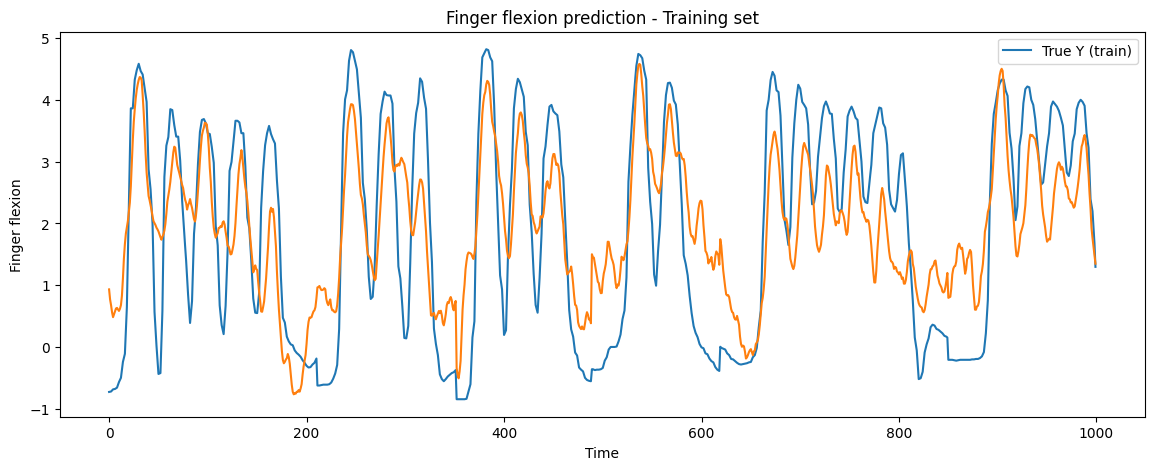

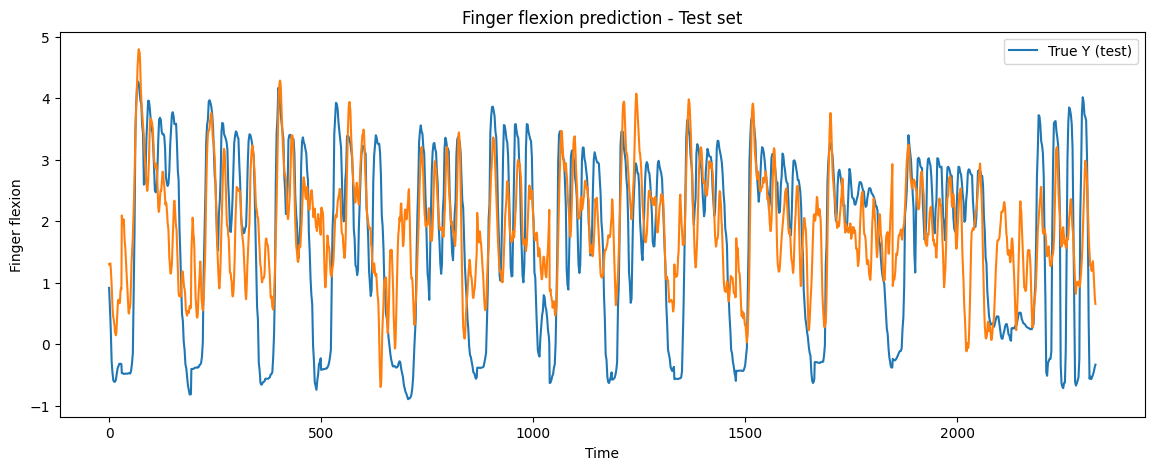

In [155]:
lasso_model = Lasso(alpha = 0.132)
lasso_model.fit(X_train, Y_train)
Y_pred_train = lasso_model.predict(X_train)
Y_pred_test = lasso_model.predict(X_test)
w = lasso_model.coef_

pl.figure(figsize=(14,5))
pl.plot(Y_train, label='True Y (train)')
pl.plot(Y_pred_train)
pl.xlabel('Time')
pl.ylabel('Finger flexion')
pl.title('Finger flexion prediction - Training set')
pl.legend()
pl.show()


pl.figure(figsize=(14,5))
pl.plot(Y_test, label='True Y (test)')
pl.plot(Y_pred_test)
pl.xlabel('Time')
pl.ylabel('Finger flexion')
pl.title('Finger flexion prediction - Test set')
pl.legend()
pl.show()

For the graph of the test set, unlike LS, which was the "zoo", Lasso follows general trends. The predictions are more “smoothed” than reality (effect of regularization).

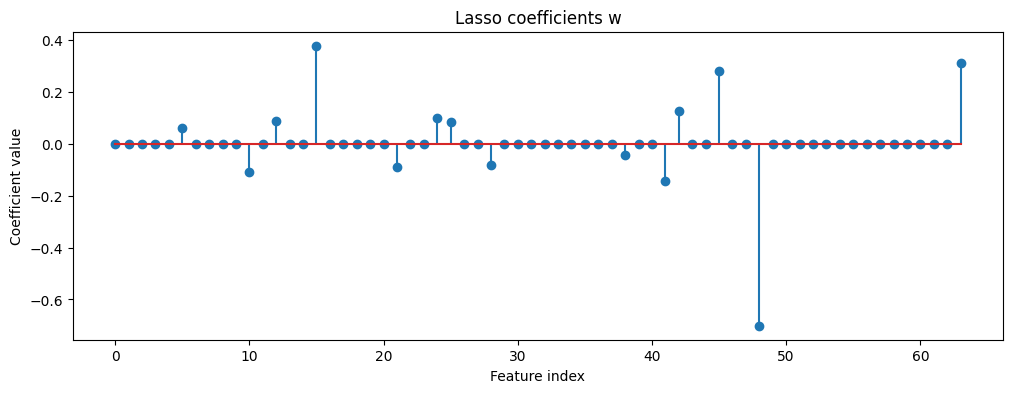

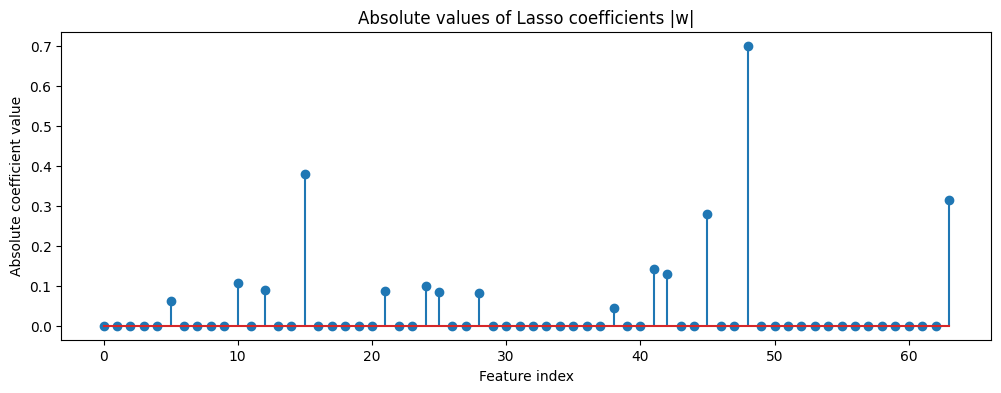

In [156]:
pl.figure(figsize=(12,4))
pl.stem(w)
pl.xlabel('Feature index')
pl.ylabel('Coefficient value')
pl.title('Lasso coefficients w')
pl.show()

pl.figure(figsize=(12,4))
pl.stem(np.abs(w))
pl.xlabel('Feature index')
pl.ylabel('Absolute coefficient value')
pl.title('Absolute values of Lasso coefficients |w|')
pl.show()

In [157]:
mse_train_Lasso_Optimized = mean_squared_error(Y_train, Y_pred_train)
mse_test_Lasso_Optimized   = mean_squared_error(Y_test, Y_pred_test)
r2_train_Lasso_Optimized   = r2_score(Y_train, Y_pred_train)
r2_test_Lasso_Optimized    = r2_score(Y_test, Y_pred_test)


print(f"MSE Train: {mse_train_Lasso_Optimized :.4f}, MSE Test: {mse_test_Lasso_Optimized :.4f}")
print(f"R² Train: {r2_train_Lasso_Optimized :.4f}, R² Test: {r2_test_Lasso_Optimized :.4f}")


MSE Train: 1.2477, MSE Test: 1.3683
R² Train: 0.6027, R² Test: 0.3583


The Lasso model has a training MSE of 1.25 and test MSE of 1.37, with R² values of 0.60 (train) and 0.36 (test), showing that it is a bit worse than Ridge. Ridge generalizes better.

In [158]:
important_features = np.argsort(np.abs(w))[-2:]
print(important_features)

[15 48]


In [159]:
w_lasso = lasso_model.coef_
selected_indices = np.where(w != 0)[0]
print("Indices of selected features:", selected_indices)
print(len(selected_indices))

Indices of selected features: [ 5 10 12 15 21 24 25 28 38 41 42 45 48 63]
14


Out of 64 original features (electrodes), the Lasso selected 14 features with non-zero coefficients, showing that only a subset of electrodes is relevant for predicting finger flexion.

Now, let's do a LS regression on a dataset that contains only the selected features and compare to the previous LS on the full dataset.

In [160]:
selected_indices = [5, 10, 12, 15, 21, 24, 25, 28, 38, 41, 42, 45, 48, 63]
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

ls_selected = linear_model.LinearRegression()
ls_selected.fit(X_train_selected, Y_train)

Y_pred_train_selected = ls_selected.predict(X_train_selected)
Y_pred_test_selected = ls_selected.predict(X_test_selected)

In [161]:

mse_train_LS_selected = mean_squared_error(Y_train, Y_pred_train_selected)
mse_test_LS_selected  = mean_squared_error(Y_test, Y_pred_test_selected)
r2_train_LS_selected  = r2_score(Y_train, Y_pred_train_selected)
r2_test_LS_selected   = r2_score(Y_test, Y_pred_test_selected)


MSE_train = mean_squared_error(Y_train, Y_train_pred)
MSE_test  = mean_squared_error(Y_test, Y_test_pred)
R_train   = r2_score(Y_train, Y_train_pred)
R_test    = r2_score(Y_test, Y_test_pred)


results = pd.DataFrame({
    "Modèle": ["Complet", "Sélectionné"],
    "MSE Train": [MSE_train_LS, mse_train_LS_selected],
    "MSE Test": [MSE_test_LS, mse_test_LS_selected],
    "R² Train": [R_train_LS, r2_train_LS_selected],
    "R² Test": [R_test_LS, r2_test_LS_selected]
})

print(results.round(4))

        Modèle  MSE Train  MSE Test  R² Train  R² Test
0      Complet     0.5041    3.0455    0.8395  -0.4282
1  Sélectionné     0.9445    1.6820    0.6992   0.2113


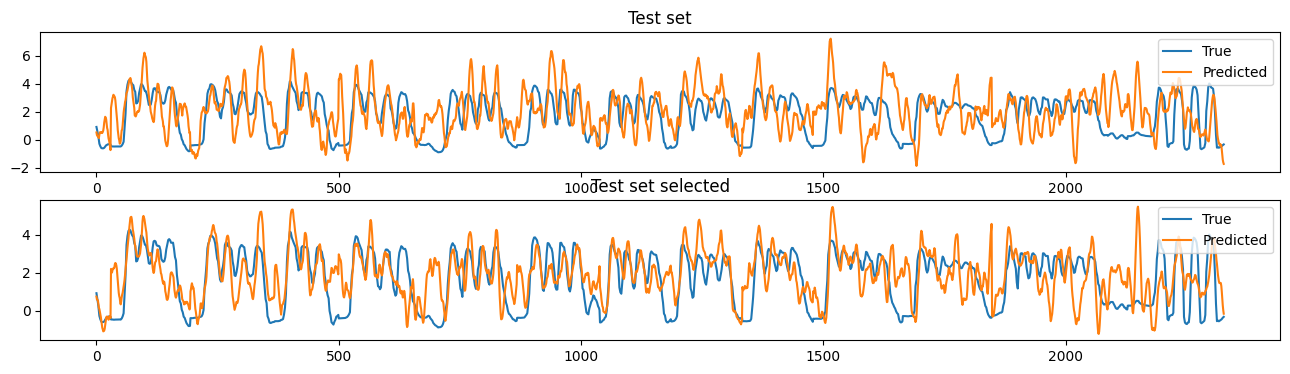

In [162]:
pl.figure(figsize=(16,4))

pl.subplot(2,1,1)
pl.plot(Y_test, label='True')
pl.plot(Y_test_pred, label='Predicted')
pl.title("Test set")
pl.legend()

pl.subplot(2,1,2)
pl.plot(Y_test, label='True')
pl.plot(Y_pred_test_selected, label='Predicted')
pl.title("Test set selected")
pl.legend()
pl.show()

The model trained on the full dataset learns very well on the training data (R² = 0.84), but performs poorly on the test data (R² = -0.43).
This means that it is too complex and overfits the training data without generalizing well.

The model with variables selected by Lasso is simpler.
Its R² on the test (0.21) is better and its error (MSE = 1.7) lower, even if its performance on the training data is slightly worse.

So the selected model generalizes better than the one on the full dataset.

Even on the graphs, we notice that the predicted curve for the selected model fits the variations of the true curve better than the one from the LS model on the full dataset.


**Comparaison of the three methods**

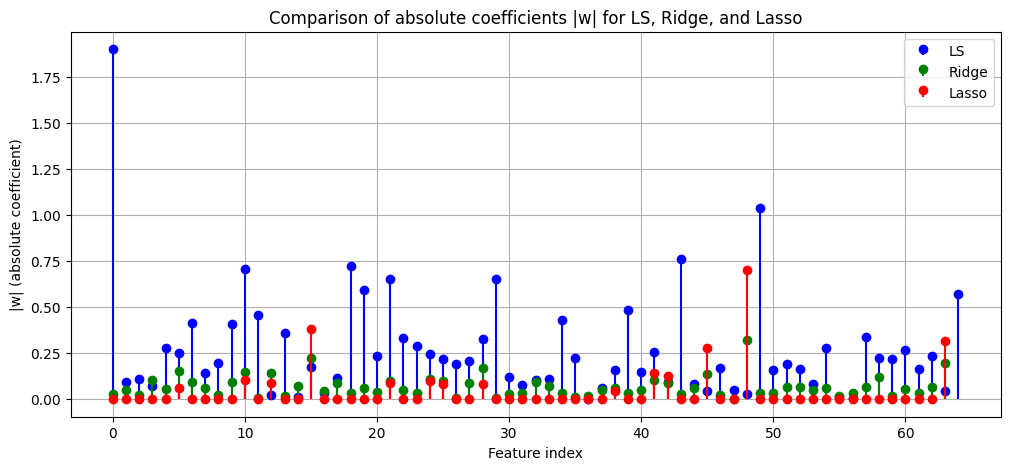

In [163]:
pl.figure(figsize=(12, 5))

pl.stem(np.abs(w_ls), linefmt='b-', markerfmt='bo', basefmt=" ", label='LS')
pl.stem(np.abs(w_ridge), linefmt='g-', markerfmt='go', basefmt=" ", label='Ridge')
pl.stem(np.abs(w_lasso), linefmt='r-', markerfmt='ro', basefmt=" ", label='Lasso')

pl.xlabel('Feature index')
pl.ylabel('|w| (absolute coefficient)')
pl.title('Comparison of absolute coefficients |w| for LS, Ridge, and Lasso')
pl.legend()
pl.grid()
pl.show()

Ridge regression : No coefficient is equal to zero, the model shrinks the values.

Lasso regression : Some of the coefficients become exacly zero. It seems that the lasso model chooses automaticly the most important variables.

Ls : Shows extreme coefficient values with some very large magnitudes (like the first coefficient at index 0), indicating potential overfitting. The coefficients appear less structured compared to the regularized methods, with some having disproportionately high values that don't reflect true feature importance but rather noise fitting.

The most importants coeffs for Lasso are the same for Ridge. But for LS, it seems that it is more randomly distributed (we can notice that with the first coeff)


**6 Nonlinear regression**

In [164]:
rf_model = RandomForestRegressor()
svr_model = SVR()
mlp_model = MLPRegressor()

# Random Forest

rf_model.fit(X_train, Y_train.ravel())
rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

rf_mse_train = mean_squared_error(Y_train.ravel(), rf_pred_train)
rf_mse_test = mean_squared_error(Y_test.ravel(), rf_pred_test)
rf_r2_train = r2_score(Y_train.ravel(), rf_pred_train)
rf_r2_test = r2_score(Y_test.ravel(), rf_pred_test)

# SVR

svr_model.fit(X_train, Y_train.ravel())
svr_pred_train = svr_model.predict(X_train)
svr_pred_test = svr_model.predict(X_test)

svr_mse_train = mean_squared_error(Y_train, svr_pred_train)
svr_mse_test = mean_squared_error(Y_test, svr_pred_test)
svr_r2_train = r2_score(Y_train, svr_pred_train)
svr_r2_test = r2_score(Y_test, svr_pred_test)

# MLP Classifier

mlp_model.fit(X_train, Y_train)
mlp_pred_train = mlp_model.predict(X_train)
mlp_pred_test = mlp_model.predict(X_test)

mlp_mse_train = mean_squared_error(Y_train, mlp_pred_train)
mlp_mse_test = mean_squared_error(Y_test, mlp_pred_test)
mlp_r2_train = r2_score(Y_train, mlp_pred_train)
mlp_r2_test = r2_score(Y_test, mlp_pred_test)

In [165]:
results_models = pd.DataFrame({
    "Modèle": ["Random Forest", "SVR", "MLP Regressor"],
    "MSE Train": [rf_mse_train, svr_mse_train, mlp_mse_train],
    "MSE Test": [rf_mse_test, svr_mse_test, mlp_mse_test],
    "R² Train": [rf_r2_train, svr_r2_train, mlp_r2_train],
    "R² Test": [rf_r2_test, svr_r2_test, mlp_r2_test]
})

print(results_models)


          Modèle  MSE Train  MSE Test  R² Train   R² Test
0  Random Forest   0.026451  1.742502  0.991578  0.182873
1            SVR   0.024086  1.515183  0.992331  0.289472
2  MLP Regressor   0.009552  2.330028  0.996958 -0.092640


It looks like our models are very efficient on the train data set: Random Forest, SVR, and MLP all score almost perfect marks, with R² values are almost 1 and MSEs practically zero.

But for the test set, it's not the same story. Random Forest(R² = 0.23) and SVR(R² = 0.29) explains the data barely more than an average. MLP(R² = -0.05) performs worse than the mean.

This clearly shows that our models are overfitting. They have learned the training data too well.

SVR has the best generalisation, it is due to the fact that it includes a regularization term that avoid overfitting.
Random Forest and SVR  models performs as well as Ridge and Lasso. But MLP Regressor generalizes to bad.

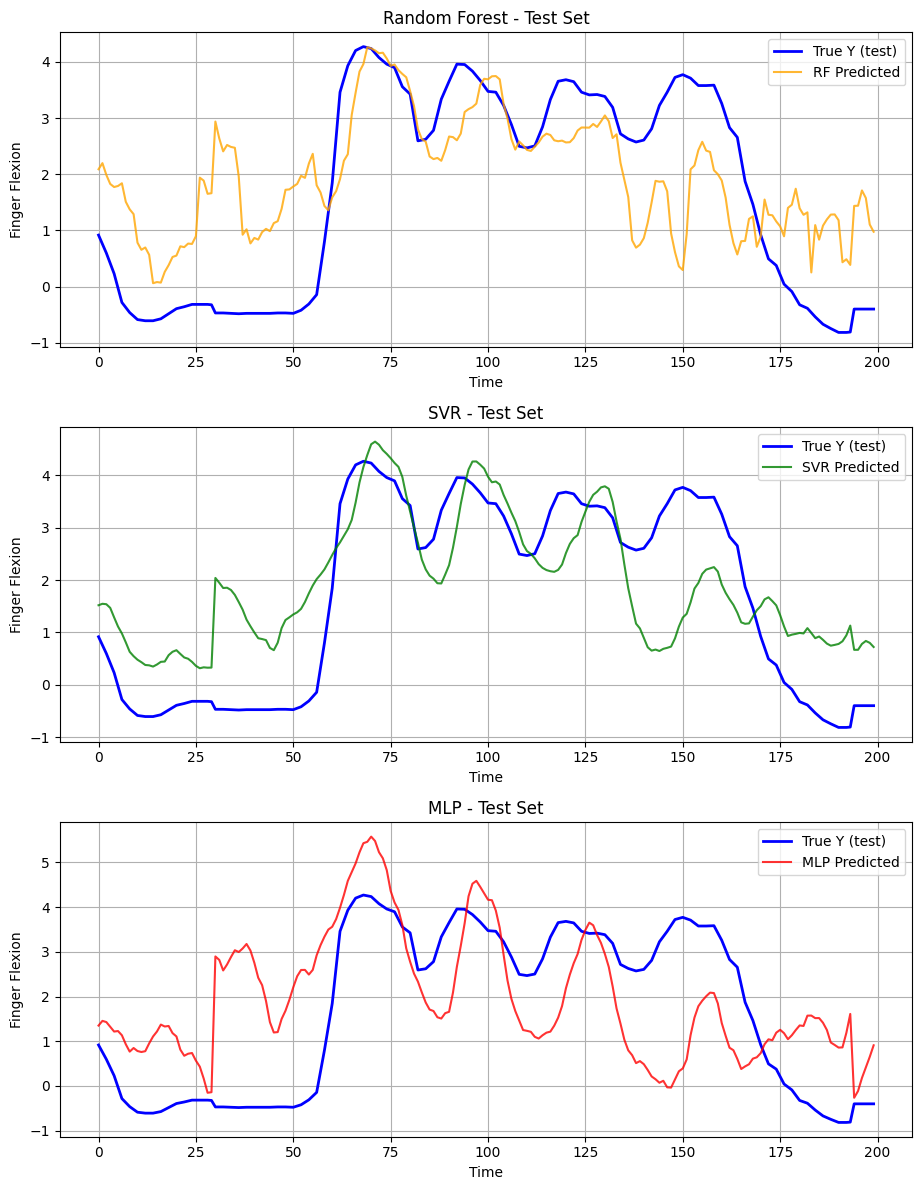

In [166]:
pl.figure(figsize=(18, 12))

pl.subplot(3, 2, 2)
pl.plot(Y_test[:200], label='True Y (test)', linewidth=2, color='blue')
pl.plot(rf_pred_test[:200], label='RF Predicted', alpha=0.8, color='orange')
pl.xlabel('Time')
pl.ylabel('Finger Flexion')
pl.title('Random Forest - Test Set')
pl.legend()
pl.grid(True)

pl.subplot(3, 2, 4)
pl.plot(Y_test[:200], label='True Y (test)', linewidth=2, color='blue')
pl.plot(svr_pred_test[:200], label='SVR Predicted', alpha=0.8, color='green')
pl.xlabel('Time')
pl.ylabel('Finger Flexion')
pl.title('SVR - Test Set')
pl.legend()
pl.grid(True)


pl.subplot(3, 2, 6)
pl.plot(Y_test[:200], label='True Y (test)', linewidth=2, color='blue')
pl.plot(mlp_pred_test[:200], label='MLP Predicted', alpha=0.8, color='red')
pl.xlabel('Time')
pl.ylabel('Finger Flexion')
pl.title('MLP - Test Set')
pl.legend()
pl.grid(True)

pl.tight_layout()
pl.show()

**Best parameters for Random Forest**

In [167]:
n_estimators_list = [10, 50, 100, 200]
mse_test_list = []

for n in n_estimators_list:
    model = RandomForestRegressor(n_estimators=n, random_state=0)
    model.fit(X_train, Y_train)
    y_pred_test = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_pred_test)
    mse_test_list.append(mse)

print("MSE test for different n_estimators:", mse_test_list)

MSE test for different n_estimators: [1.9194800329606705, 1.683951676767301, 1.64281562414951, 1.649367028175709]


The MSE test does generally decrease as the number of estimators increases, but there's a slight increase from 100 to 200 estimators (1.635 → 1.642). This suggests that around 100 estimators might be the optimal point for this dataset.

In [168]:
print("Testing n_estimators around optimal range:")

print("Testing RF Configuration 1: n_estimators=80")
rf1 = RandomForestRegressor(n_estimators=80, random_state=42)
rf1.fit(X_train, Y_train.ravel())
rf1_pred = rf1.predict(X_test)
rf1_mse = mean_squared_error(Y_test, rf1_pred)
rf1_r2 = r2_score(Y_test, rf1_pred)
print(f"MSE: {rf1_mse:.4f}, R²: {rf1_r2:.4f}")

print("\nTesting RF Configuration 2: n_estimators=90")
rf2 = RandomForestRegressor(n_estimators=90, random_state=42)
rf2.fit(X_train, Y_train.ravel())
rf2_pred = rf2.predict(X_test)
rf2_mse = mean_squared_error(Y_test, rf2_pred)
rf2_r2 = r2_score(Y_test, rf2_pred)
print(f"MSE: {rf2_mse:.4f}, R²: {rf2_r2:.4f}")

print("\nTesting RF Configuration 3: n_estimators=100")
rf3 = RandomForestRegressor(n_estimators=100, random_state=42)
rf3.fit(X_train, Y_train.ravel())
rf3_pred = rf3.predict(X_test)
rf3_mse = mean_squared_error(Y_test, rf3_pred)
rf3_r2 = r2_score(Y_test, rf3_pred)
print(f"MSE: {rf3_mse:.4f}, R²: {rf3_r2:.4f}")

print("\nTesting RF Configuration 4: n_estimators=110")
rf4 = RandomForestRegressor(n_estimators=110, random_state=42)
rf4.fit(X_train, Y_train.ravel())
rf4_pred = rf4.predict(X_test)
rf4_mse = mean_squared_error(Y_test, rf4_pred)
rf4_r2 = r2_score(Y_test, rf4_pred)
print(f"MSE: {rf4_mse:.4f}, R²: {rf4_r2:.4f}")

rf_configs_1 = [
    ("Config 1: n_estimators=80", rf1_mse, rf1_r2, 80),
    ("Config 2: n_estimators=90", rf2_mse, rf2_r2, 90),
    ("Config 3: n_estimators=100", rf3_mse, rf3_r2, 100),
    ("Config 4: n_estimators=110", rf4_mse, rf4_r2, 110)
]

best_n_config = min(rf_configs_1, key=lambda x: x[1])
best_n_estimators = best_n_config[3]
print(f"\nBest n_estimators configuration: {best_n_config[0]}")
print(f"MSE: {best_n_config[1]:.4f}, R²: {best_n_config[2]:.4f}")

Testing n_estimators around optimal range:
Testing RF Configuration 1: n_estimators=80
MSE: 1.6429, R²: 0.2296

Testing RF Configuration 2: n_estimators=90
MSE: 1.6272, R²: 0.2370

Testing RF Configuration 3: n_estimators=100
MSE: 1.6257, R²: 0.2377

Testing RF Configuration 4: n_estimators=110
MSE: 1.6306, R²: 0.2353

Best n_estimators configuration: Config 3: n_estimators=100
MSE: 1.6257, R²: 0.2377


When we look at the MSE and the R², we see that the optimal range is between 90-110. Which confirms what we found with the previous method

In [169]:
print("Testing RF Configuration 1: max_depth=None (unlimited)")
rf_depth1 = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=None, random_state=42)
rf_depth1.fit(X_train, Y_train.ravel())
rf_depth1_pred = rf_depth1.predict(X_test)
rf_depth1_mse = mean_squared_error(Y_test, rf_depth1_pred)
rf_depth1_r2 = r2_score(Y_test, rf_depth1_pred)
print(f"MSE: {rf_depth1_mse:.4f}, R²: {rf_depth1_r2:.4f}")

print("\nTesting RF Configuration 2: max_depth=10")
rf_depth2 = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=10, random_state=42)
rf_depth2.fit(X_train, Y_train.ravel())
rf_depth2_pred = rf_depth2.predict(X_test)
rf_depth2_mse = mean_squared_error(Y_test, rf_depth2_pred)
rf_depth2_r2 = r2_score(Y_test, rf_depth2_pred)
print(f"MSE: {rf_depth2_mse:.4f}, R²: {rf_depth2_r2:.4f}")

print("\nTesting RF Configuration 3: max_depth=15")
rf_depth3 = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=15, random_state=42)
rf_depth3.fit(X_train, Y_train.ravel())
rf_depth3_pred = rf_depth3.predict(X_test)
rf_depth3_mse = mean_squared_error(Y_test, rf_depth3_pred)
rf_depth3_r2 = r2_score(Y_test, rf_depth3_pred)
print(f"MSE: {rf_depth3_mse:.4f}, R²: {rf_depth3_r2:.4f}")

rf_configs_2 = [
    ("Config 1: max_depth=None", rf_depth1_mse, rf_depth1_r2, None),
    ("Config 2: max_depth=10", rf_depth2_mse, rf_depth2_r2, 10),
    ("Config 3: max_depth=15", rf_depth3_mse, rf_depth3_r2, 15)
]

best_depth_config = min(rf_configs_2, key=lambda x: x[1])
best_max_depth = best_depth_config[3]
print(f"\nBest max_depth configuration: {best_depth_config[0]}")
print(f"MSE: {best_depth_config[1]:.4f}, R²: {best_depth_config[2]:.4f}")

Testing RF Configuration 1: max_depth=None (unlimited)
MSE: 1.6257, R²: 0.2377

Testing RF Configuration 2: max_depth=10
MSE: 1.6349, R²: 0.2333

Testing RF Configuration 3: max_depth=15
MSE: 1.6394, R²: 0.2312

Best max_depth configuration: Config 1: max_depth=None
MSE: 1.6257, R²: 0.2377


With the unlimited performance (max_depth = None), we have the lowest MSE = 1.6273 and the higher R² = 0.2369. If we limit the depth, the model has difficulty capturing the neural patterns.

In [170]:
print("Testing RF Configuration 1: min_samples_split=2")
rf_split1 = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=2,
    random_state=42
)
rf_split1.fit(X_train, Y_train.ravel())
rf_split1_pred = rf_split1.predict(X_test)
rf_split1_mse = mean_squared_error(Y_test, rf_split1_pred)
rf_split1_r2 = r2_score(Y_test, rf_split1_pred)
print(f"MSE: {rf_split1_mse:.4f}, R²: {rf_split1_r2:.4f}")

print("\nTesting RF Configuration 2: min_samples_split=5")
rf_split2 = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=5,
    random_state=42
)
rf_split2.fit(X_train, Y_train.ravel())
rf_split2_pred = rf_split2.predict(X_test)
rf_split2_mse = mean_squared_error(Y_test, rf_split2_pred)
rf_split2_r2 = r2_score(Y_test, rf_split2_pred)
print(f"MSE: {rf_split2_mse:.4f}, R²: {rf_split2_r2:.4f}")

print("\nTesting RF Configuration 3: min_samples_split=10")
rf_split3 = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=10,
    random_state=42
)
rf_split3.fit(X_train, Y_train.ravel())
rf_split3_pred = rf_split3.predict(X_test)
rf_split3_mse = mean_squared_error(Y_test, rf_split3_pred)
rf_split3_r2 = r2_score(Y_test, rf_split3_pred)
print(f"MSE: {rf_split3_mse:.4f}, R²: {rf_split3_r2:.4f}")


rf_configs_3 = [
    ("Config 1: min_samples_split=2", rf_split1_mse, rf_split1_r2, 2),
    ("Config 2: min_samples_split=5", rf_split2_mse, rf_split2_r2, 5),
    ("Config 3: min_samples_split=10", rf_split3_mse, rf_split3_r2, 10)
]

best_split_config = min(rf_configs_3, key=lambda x: x[1])
best_min_samples_split = best_split_config[3]
print(f"\nBest min_samples_split configuration: {best_split_config[0]}")
print(f"MSE: {best_split_config[1]:.4f}, R²: {best_split_config[2]:.4f}")


print(f"Original RF: MSE = {rf_mse_test:.4f}, R² = {rf_r2_test:.4f}")
print(f"Best manual RF: MSE = {best_split_config[1]:.4f}, R² = {best_split_config[2]:.4f}")
print(f"Optimal parameters: n_estimators={best_n_estimators}, max_depth={best_max_depth}, min_samples_split={best_min_samples_split}")

Testing RF Configuration 1: min_samples_split=2
MSE: 1.6257, R²: 0.2377

Testing RF Configuration 2: min_samples_split=5
MSE: 1.6416, R²: 0.2302

Testing RF Configuration 3: min_samples_split=10
MSE: 1.6401, R²: 0.2309

Best min_samples_split configuration: Config 1: min_samples_split=2
MSE: 1.6257, R²: 0.2377
Original RF: MSE = 1.7425, R² = 0.1829
Best manual RF: MSE = 1.6257, R² = 0.2377
Optimal parameters: n_estimators=100, max_depth=None, min_samples_split=2


ECoG signals contain subtle temporal variations that require maximum resolution to capture brain-to-movement relationsips. While electrodes 45 and 48 are among the most important features (identified by Lasso), the dataset still benefits to detect small patterns across all electrodes.
Testing showed min_samples_split=2 achieved the best performance (MSE=1.6273, R²=0.2369) compared to higher values. So the result of Lasso confirms that we take min_samples = 2.

In [171]:
rf_optimized_model = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    random_state=42
)
rf_optimized_model.fit(X_train, Y_train.ravel())
rf_optimized_pred_test = rf_optimized_model.predict(X_test)

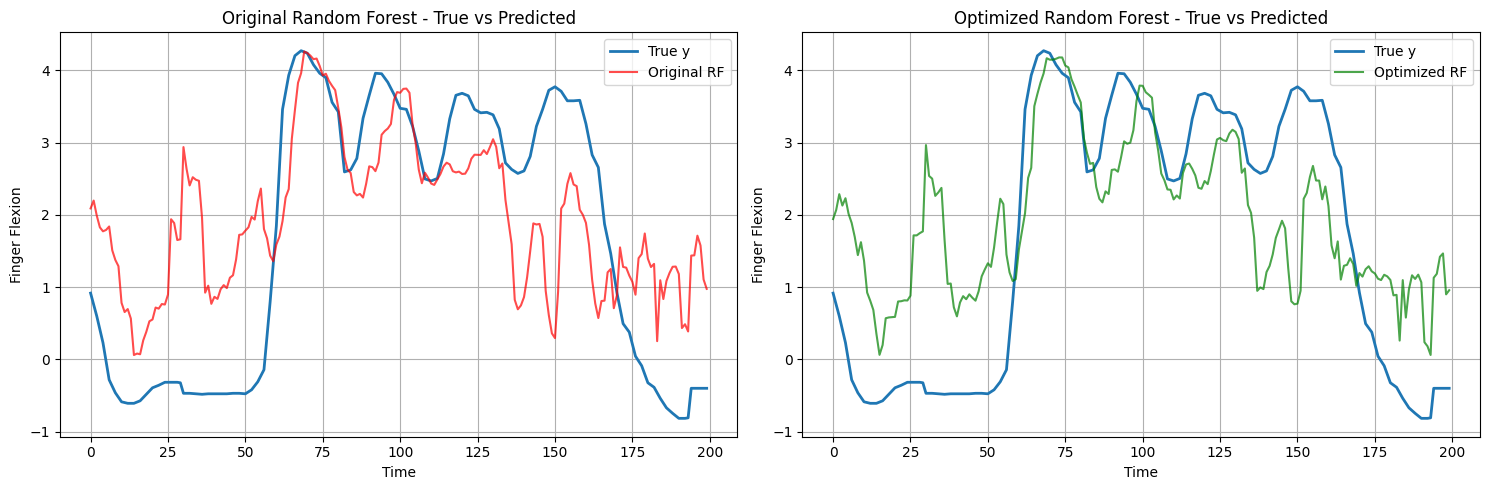

In [172]:
pl.figure(figsize=(15, 5))

pl.subplot(1, 2, 1)
pl.plot(Y_test[:200], label='True y', linewidth=2)
pl.plot(rf_pred_test[:200], label='Original RF', alpha=0.7, color='red')
pl.xlabel('Time')
pl.ylabel('Finger Flexion')
pl.title('Original Random Forest - True vs Predicted')
pl.legend()
pl.grid(True)

pl.subplot(1, 2, 2)
pl.plot(Y_test[:200], label='True y', linewidth=2)
pl.plot(rf_optimized_pred_test[:200], label='Optimized RF', alpha=0.7, color='green')
pl.xlabel('Time')
pl.ylabel('Finger Flexion')
pl.title('Optimized Random Forest - True vs Predicted')
pl.legend()
pl.grid(True)

pl.tight_layout()
pl.show()

**Best parameters for SVR**

In [173]:
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10, 100]

svr_results = []

for kernel in kernels:
    for C in C_values:
        svr_model = SVR(kernel=kernel, C=C)
        svr_model.fit(X_train, Y_train.ravel())


        svr_pred_test = svr_model.predict(X_test)


        mse_test = mean_squared_error(Y_test, svr_pred_test)
        r2_test = r2_score(Y_test, svr_pred_test)

        svr_results.append({
            'kernel': kernel,
            'C': C,
            'mse_test': mse_test,
            'r2_test': r2_test
        })

        print(f"Kernel: {kernel}, C: {C} -> MSE: {mse_test:.4f}, R²: {r2_test:.4f}")


best_svr = min(svr_results, key=lambda x: x['mse_test'])
print(f"\nBest SVR parameters: {best_svr}")


print(f"\nOriginal SVR: MSE = {svr_mse_test:.4f}, R² = {svr_r2_test:.4f}")
print(f"Optimized SVR: MSE = {best_svr['mse_test']:.4f}, R² = {best_svr['r2_test']:.4f}")

Kernel: linear, C: 0.1 -> MSE: 2.5813, R²: -0.2105
Kernel: linear, C: 1 -> MSE: 2.8344, R²: -0.3291
Kernel: linear, C: 10 -> MSE: 2.8678, R²: -0.3448
Kernel: linear, C: 100 -> MSE: 2.8820, R²: -0.3515
Kernel: rbf, C: 0.1 -> MSE: 1.7368, R²: 0.1855
Kernel: rbf, C: 1 -> MSE: 1.5152, R²: 0.2895
Kernel: rbf, C: 10 -> MSE: 1.5532, R²: 0.2716
Kernel: rbf, C: 100 -> MSE: 1.5921, R²: 0.2534
Kernel: poly, C: 0.1 -> MSE: 1.9794, R²: 0.0718
Kernel: poly, C: 1 -> MSE: 2.2225, R²: -0.0422
Kernel: poly, C: 10 -> MSE: 2.5312, R²: -0.1870
Kernel: poly, C: 100 -> MSE: 2.6574, R²: -0.2462

Best SVR parameters: {'kernel': 'rbf', 'C': 1, 'mse_test': 1.515182870123942, 'r2_test': 0.28947213490412815}

Original SVR: MSE = 1.5152, R² = 0.2895
Optimized SVR: MSE = 1.5152, R² = 0.2895


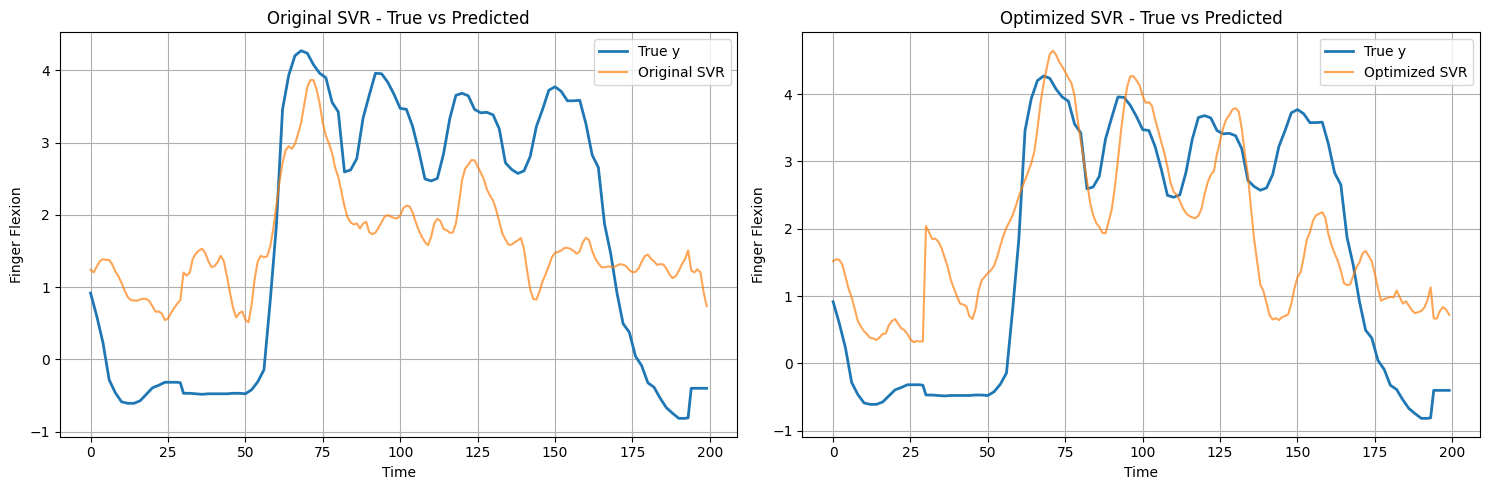

In [174]:
best_svr_model = SVR(kernel=best_svr['kernel'], C=best_svr['C'])
best_svr_model.fit(X_train, Y_train.ravel())
best_svr_pred_test = best_svr_model.predict(X_test)

pl.figure(figsize=(15, 5))

pl.subplot(1, 2, 1)
pl.plot(Y_test[:200], label='True y', linewidth=2)
pl.plot(svr_pred_test[:200], label='Original SVR', alpha=0.7)
pl.xlabel('Time')
pl.ylabel('Finger Flexion')
pl.title('Original SVR - True vs Predicted')
pl.legend()
pl.grid(True)

pl.subplot(1, 2, 2)
pl.plot(Y_test[:200], label='True y', linewidth=2)
pl.plot(best_svr_pred_test[:200], label='Optimized SVR', alpha=0.7)
pl.xlabel('Time')
pl.ylabel('Finger Flexion')
pl.title('Optimized SVR - True vs Predicted')
pl.legend()
pl.grid(True)

pl.tight_layout()
pl.show()

After executing the test, original SVR and Optimized SVR are still the same. I think this can be understable because the scickit-learn library have defaukt values well choosed. But this is funny because the curves are not the same but the parameters

Best regularization for MLP Regressor

In [175]:
print("Testing MLP Configuration 1: alpha=0.001")
mlp_alpha1 = MLPRegressor(
    hidden_layer_sizes=(100,),
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)
mlp_alpha1.fit(X_train, Y_train.ravel())
mlp_alpha1_pred = mlp_alpha1.predict(X_test)
mlp_alpha1_mse = mean_squared_error(Y_test, mlp_alpha1_pred)
mlp_alpha1_r2 = r2_score(Y_test, mlp_alpha1_pred)
print(f"MSE: {mlp_alpha1_mse:.4f}, R²: {mlp_alpha1_r2:.4f}")

print("\nTesting MLP Configuration 2: alpha=0.01")
mlp_alpha2 = MLPRegressor(
    hidden_layer_sizes=(100,),
    alpha=0.01,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)
mlp_alpha2.fit(X_train, Y_train.ravel())
mlp_alpha2_pred = mlp_alpha2.predict(X_test)
mlp_alpha2_mse = mean_squared_error(Y_test, mlp_alpha2_pred)
mlp_alpha2_r2 = r2_score(Y_test, mlp_alpha2_pred)
print(f"MSE: {mlp_alpha2_mse:.4f}, R²: {mlp_alpha2_r2:.4f}")

print("\nTesting MLP Configuration 3: alpha=0.1")
mlp_alpha3 = MLPRegressor(
    hidden_layer_sizes=(100,),
    alpha=0.1,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)
mlp_alpha3.fit(X_train, Y_train.ravel())
mlp_alpha3_pred = mlp_alpha3.predict(X_test)
mlp_alpha3_mse = mean_squared_error(Y_test, mlp_alpha3_pred)
mlp_alpha3_r2 = r2_score(Y_test, mlp_alpha3_pred)
print(f"MSE: {mlp_alpha3_mse:.4f}, R²: {mlp_alpha3_r2:.4f}")

mlp_alpha_configs = [
    ("Config 1: alpha=0.001", mlp_alpha1_mse, mlp_alpha1_r2, 0.001),
    ("Config 2: alpha=0.01", mlp_alpha2_mse, mlp_alpha2_r2, 0.01),
    ("Config 3: alpha=0.1", mlp_alpha3_mse, mlp_alpha3_r2, 0.1)
]

best_alpha_config = min(mlp_alpha_configs, key=lambda x: x[1])
best_alpha = best_alpha_config[3]
print(f"\nBest alpha configuration: {best_alpha_config[0]}")
print(f"MSE: {best_alpha_config[1]:.4f}, R²: {best_alpha_config[2]:.4f}")


Testing MLP Configuration 1: alpha=0.001
MSE: 2.5369, R²: -0.1897

Testing MLP Configuration 2: alpha=0.01
MSE: 2.5363, R²: -0.1893

Testing MLP Configuration 3: alpha=0.1
MSE: 2.5073, R²: -0.1758

Best alpha configuration: Config 3: alpha=0.1
MSE: 2.5073, R²: -0.1758


alpha = 0.1 achieved the best performance, with the lowest MSE and the least negative R², indicating it captures the variance in the data slightly better than the other configurations.

In [176]:
print("Testing MLP Configuration 1: hidden_layer_sizes=(50,)")
mlp_hidden1 = MLPRegressor(
    hidden_layer_sizes=(50,),
    alpha=best_alpha,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)
mlp_hidden1.fit(X_train, Y_train.ravel())
mlp_hidden1_pred = mlp_hidden1.predict(X_test)
mlp_hidden1_mse = mean_squared_error(Y_test, mlp_hidden1_pred)
mlp_hidden1_r2 = r2_score(Y_test, mlp_hidden1_pred)
print(f"MSE: {mlp_hidden1_mse:.4f}, R²: {mlp_hidden1_r2:.4f}")

print("\nTesting MLP Configuration 2: hidden_layer_sizes=(100,)")
mlp_hidden2 = MLPRegressor(
    hidden_layer_sizes=(100,),
    alpha=best_alpha,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)
mlp_hidden2.fit(X_train, Y_train.ravel())
mlp_hidden2_pred = mlp_hidden2.predict(X_test)
mlp_hidden2_mse = mean_squared_error(Y_test, mlp_hidden2_pred)
mlp_hidden2_r2 = r2_score(Y_test, mlp_hidden2_pred)
print(f"MSE: {mlp_hidden2_mse:.4f}, R²: {mlp_hidden2_r2:.4f}")

print("\nTesting MLP Configuration 3: hidden_layer_sizes=(50, 50)")
mlp_hidden3 = MLPRegressor(
    hidden_layer_sizes=(50, 50),
    alpha=best_alpha,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)
mlp_hidden3.fit(X_train, Y_train.ravel())
mlp_hidden3_pred = mlp_hidden3.predict(X_test)
mlp_hidden3_mse = mean_squared_error(Y_test, mlp_hidden3_pred)
mlp_hidden3_r2 = r2_score(Y_test, mlp_hidden3_pred)
print(f"MSE: {mlp_hidden3_mse:.4f}, R²: {mlp_hidden3_r2:.4f}")

mlp_hidden_configs = [
    ("Config 1: hidden_layer_sizes=(50,)", mlp_hidden1_mse, mlp_hidden1_r2, (50,)),
    ("Config 2: hidden_layer_sizes=(100,)", mlp_hidden2_mse, mlp_hidden2_r2, (100,)),
    ("Config 3: hidden_layer_sizes=(50,50)", mlp_hidden3_mse, mlp_hidden3_r2, (50, 50))
]

best_hidden_config = min(mlp_hidden_configs, key=lambda x: x[1])
best_hidden_layers = best_hidden_config[3]
print(f"\nBest hidden layer configuration: {best_hidden_config[0]}")
print(f"MSE: {best_hidden_config[1]:.4f}, R²: {best_hidden_config[2]:.4f}")

Testing MLP Configuration 1: hidden_layer_sizes=(50,)
MSE: 2.2175, R²: -0.0399

Testing MLP Configuration 2: hidden_layer_sizes=(100,)
MSE: 2.5073, R²: -0.1758

Testing MLP Configuration 3: hidden_layer_sizes=(50, 50)
MSE: 2.1205, R²: 0.0056

Best hidden layer configuration: Config 3: hidden_layer_sizes=(50,50)
MSE: 2.1205, R²: 0.0056


two hidden layers with 50 neurons each achieved the best performance, with the lowest MSE and a slightly positive R², indicating it captures the variance in the data better than the other configurations.

In [177]:
print("Testing MLP Configuration 1: learning_rate_init=0.0001")
mlp_lr1 = MLPRegressor(
    hidden_layer_sizes=best_hidden_layers,
    alpha=best_alpha,
    learning_rate_init=0.0001,
    max_iter=1000,
    random_state=42
)
mlp_lr1.fit(X_train, Y_train.ravel())
mlp_lr1_pred = mlp_lr1.predict(X_test)
mlp_lr1_mse = mean_squared_error(Y_test, mlp_lr1_pred)
mlp_lr1_r2 = r2_score(Y_test, mlp_lr1_pred)
print(f"MSE: {mlp_lr1_mse:.4f}, R²: {mlp_lr1_r2:.4f}")

print("\nTesting MLP Configuration 2: learning_rate_init=0.001")
mlp_lr2 = MLPRegressor(
    hidden_layer_sizes=best_hidden_layers,
    alpha=best_alpha,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)
mlp_lr2.fit(X_train, Y_train.ravel())
mlp_lr2_pred = mlp_lr2.predict(X_test)
mlp_lr2_mse = mean_squared_error(Y_test, mlp_lr2_pred)
mlp_lr2_r2 = r2_score(Y_test, mlp_lr2_pred)
print(f"MSE: {mlp_lr2_mse:.4f}, R²: {mlp_lr2_r2:.4f}")

print("\nTesting MLP Configuration 3: learning_rate_init=0.01")
mlp_lr3 = MLPRegressor(
    hidden_layer_sizes=best_hidden_layers,
    alpha=best_alpha,
    learning_rate_init=0.01,
    max_iter=1000,
    random_state=42
)
mlp_lr3.fit(X_train, Y_train.ravel())
mlp_lr3_pred = mlp_lr3.predict(X_test)
mlp_lr3_mse = mean_squared_error(Y_test, mlp_lr3_pred)
mlp_lr3_r2 = r2_score(Y_test, mlp_lr3_pred)
print(f"MSE: {mlp_lr3_mse:.4f}, R²: {mlp_lr3_r2:.4f}")

mlp_lr_configs = [
    ("Config 1: learning_rate_init=0.0001", mlp_lr1_mse, mlp_lr1_r2, 0.0001),
    ("Config 2: learning_rate_init=0.001", mlp_lr2_mse, mlp_lr2_r2, 0.001),
    ("Config 3: learning_rate_init=0.01", mlp_lr3_mse, mlp_lr3_r2, 0.01)
]

best_lr_config = min(mlp_lr_configs, key=lambda x: x[1])
best_learning_rate = best_lr_config[3]
print(f"\nBest learning rate configuration: {best_lr_config[0]}")
print(f"MSE: {best_lr_config[1]:.4f}, R²: {best_lr_config[2]:.4f}")


mlp_results = []
mlp_results.extend([
    {'config': config[0], 'mse_test': config[1], 'r2_test': config[2]}
    for config in mlp_alpha_configs + mlp_hidden_configs + mlp_lr_configs
])

best_mlp = min(mlp_results, key=lambda x: x['mse_test'])
print(f"\nBest MLP parameters: {best_mlp}")

print(f"\nOriginal MLP: MSE = {mlp_mse_test:.4f}, R² = {mlp_r2_test:.4f}")
print(f"Optimized MLP: MSE = {best_mlp['mse_test']:.4f}, R² = {best_mlp['r2_test']:.4f}")

Testing MLP Configuration 1: learning_rate_init=0.0001
MSE: 1.9461, R²: 0.0874

Testing MLP Configuration 2: learning_rate_init=0.001
MSE: 2.1205, R²: 0.0056

Testing MLP Configuration 3: learning_rate_init=0.01
MSE: 2.1274, R²: 0.0024

Best learning rate configuration: Config 1: learning_rate_init=0.0001
MSE: 1.9461, R²: 0.0874

Best MLP parameters: {'config': 'Config 1: learning_rate_init=0.0001', 'mse_test': 1.9461386463613302, 'r2_test': 0.08738029920667334}

Original MLP: MSE = 2.3300, R² = -0.0926
Optimized MLP: MSE = 1.9461, R² = 0.0874


learning rate = 0.0001 achieved the best performance, with the lowest MSE and the highest R².

The optimized model significantly improves prediction accuracy, both reducing error and better capturing variance in the data.

In [178]:
mlp_optimized_model = MLPRegressor(
    hidden_layer_sizes=best_hidden_layers,
    alpha=best_alpha,
    learning_rate_init=best_learning_rate,
    max_iter=1000,
    random_state=42
)
mlp_optimized_model.fit(X_train, Y_train.ravel())
mlp_optimized_pred_test = mlp_optimized_model.predict(X_test)

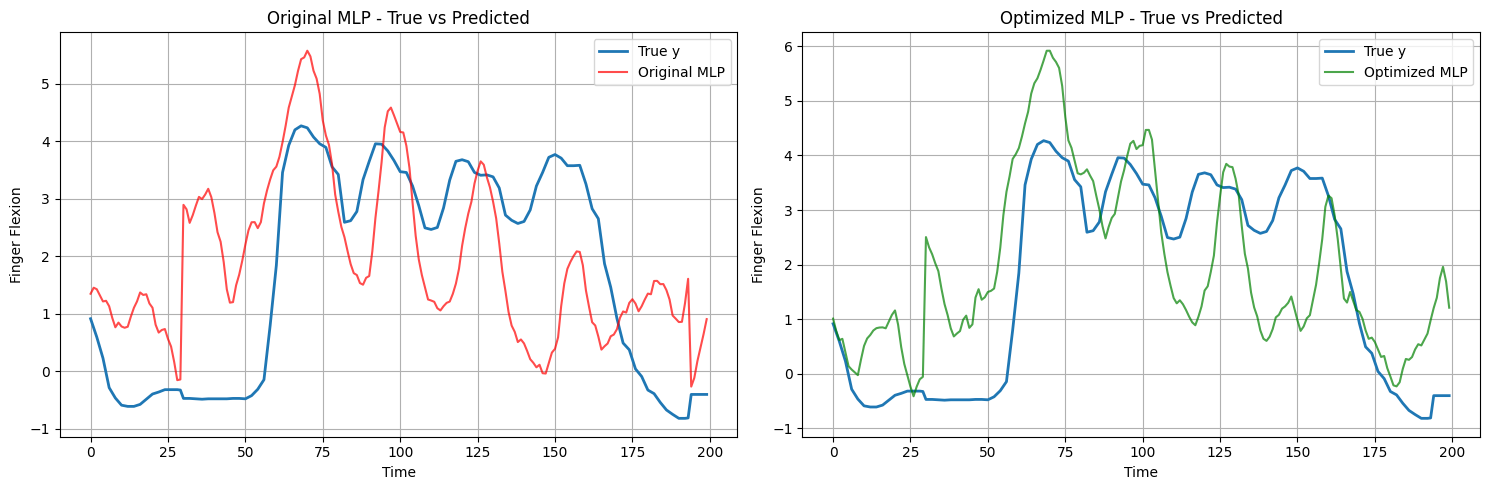

In [179]:
pl.figure(figsize=(15, 5))

pl.subplot(1, 2, 1)
pl.plot(Y_test[:200], label='True y', linewidth=2)
pl.plot(mlp_pred_test[:200], label='Original MLP', alpha=0.7, color='red')
pl.xlabel('Time')
pl.ylabel('Finger Flexion')
pl.title('Original MLP - True vs Predicted')
pl.legend()
pl.grid(True)

pl.subplot(1, 2, 2)
pl.plot(Y_test[:200], label='True y', linewidth=2)
pl.plot(mlp_optimized_pred_test[:200], label='Optimized MLP', alpha=0.7, color='green')
pl.xlabel('Time')
pl.ylabel('Finger Flexion')
pl.title('Optimized MLP - True vs Predicted')
pl.legend()
pl.grid(True)

pl.tight_layout()
pl.show()

riginal MLP (left):

- Produces more important extreme amplitude spikes
- It shows severe overfitting with random noise-like behavior

Optimized MLP (right):

- Now follows better with less extreme amplitude spikes
- Shows significant improvement in prediction stability and realism


**7 Final comparison of the performances**

In [180]:
performance_data = {
    'Model': [
        'Least Squares (Full)',
        'Least Squares (Selected)',
        'Ridge (α=954)',
        'Lasso (α=0.132)',
        'Random Forest (Original)',
        'Random Forest (Optimized)',
        'SVR (Original)',
        'SVR (Optimized)',
        'MLP (Original)',
        'MLP (Optimized)'
    ],
    'MSE Test': [
        MSE_test_LS,
        mse_test_LS_selected,
        mse_test_Ridge_Optimized,
        mse_test_Lasso_Optimized,
        rf_mse_test,
        best_split_config[1],
        svr_mse_test,
        best_svr['mse_test'],
        mlp_mse_test,
        best_mlp['mse_test']
    ],
    'R² Test': [
        R_test_LS,
        r2_test_LS_selected,
        r2_test_Ridge_Optimized,
        r2_test_Lasso_Optimized,
        rf_r2_test,
        best_split_config[2],
        svr_r2_test,
        best_svr['r2_test'],
        mlp_r2_test,
        best_mlp['r2_test']
    ],
    'Features Used': [
        64,
        14,
        64,
        64,
        64,
        64,
        64,
        64,
        64,
        64
    ],
}

results_df = pd.DataFrame(performance_data)
results_df = results_df.sort_values('MSE Test')
print(results_df)

                       Model  MSE Test   R² Test  Features Used
3            Lasso (α=0.132)  1.368325  0.358339             64
7            SVR (Optimized)  1.515183  0.289472             64
6             SVR (Original)  1.515183  0.289472             64
2              Ridge (α=954)  1.623902  0.238489             64
5  Random Forest (Optimized)  1.625684  0.237654             64
1   Least Squares (Selected)  1.681982  0.211253             14
4   Random Forest (Original)  1.742502  0.182873             64
9            MLP (Optimized)  1.946139  0.087380             64
8             MLP (Original)  2.330028 -0.092640             64
0       Least Squares (Full)  3.045537 -0.428170             64


To conclude, I didn't optimize the three models, I found how do we have to choose the parameters to have the best results. Furthemore, here are my interpretation of the use of the models studied :

1. Lasso, Ridge, and Least Squares are the most interpretable.

Their linear nature allows each feature’s coefficient to be directly understood, which is critical in a medical or practical context.

Also when we optimize Lasso (α=0.132). It becomes particularly interpretable because it uses feature selection to reduce the number of active predictors while keeping most important ones wich can be really interesting when the dataset are big.

SVR, Random Forest, and MLP are more complex models, it is very difficult to optimize them because there are too much parameters.

2. Best model from a medical/practical perspective:

Lasso (α=0.132) achieves the lowest test MSE (1.368) and the highest R² (0.358) among all models. This model is a game changer because of it's ability to make dimensionnality reduction on the data. However with a lot of more features, lasso could be worse.

For medical applications, interpretability and consistent performance are essential, so Lasso is the preferred choice accordingly to our results.

3. Do we need non-linearity in this application?

Non-linear models (SVR, Random Forest, MLP) seem to be not very effective for that application when we look at their perfomances. This suggests the relationships in the data are largely linear.

4. Validation on the test data:

No, using the test data for model selection is not good practice. The test set should only evaluate the final model.

if, during my internship, I need to provide a model to a client for prediction in production, I may do :

- Split data into training, validation, and test sets.

- Use the validation set for hyperparameter tuning (ex :  α in Lasso, C in SVR).

- Reserve the test set for final performance reporting.

- Cross-validation can help if the dataset is small.

**CONCLUSION**

The role of AI in the medical field will be crucial in the coming years and should not be taken lightly. Its applications have the potential to greatly improve diagnosis, treatment planning etc... Careful validation, interpretability are vital to responsibly manage AI-driven solutions in healthcare, where errors can have significant consequences.